<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================================================
# GQR proton TDSE on a translucent Mn4CaO5 scaffold (3D animation)
#  - mmCIF → scaffold (Mn, Ca, nearby O/N, waters)
#  - H→I→J time windows (8F4H/I/J) => geom interpolation
#  - Graph Hamiltonian (distance-weighted hopping)
#  - Fast e- bias: TyrZ → Mn edge softening (time-oscillatory)
#  - Optional sink near W3/W4 (thylakoid drain)
#  - Crank–Nicolson TDSE propagation
#  - 3D MP4/GIF + kymograph
# ================================================================
import os, math, numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
np.set_printoptions(suppress=True, linewidth=140)

# --------- Config (tweak freely) ----------
CIF_H = "/content/8F4H.cif"
CIF_I = "/content/8F4I.cif"
CIF_J = "/content/8F4J.cif"
OUTDIR = "/content" if os.path.isdir("/content") else "."
T_ms   = 4.0         # total duration (ms)
tH_ms, tI_ms, tJ_ms = 0.80, 1.60, 4.00   # window endpoints
dt_us  = 2.0         # time step (µs)
snap_stride = 6      # save every Nth frame

# Graph / Hamiltonian params
J0      = 0.12       # base hopping magnitude (arb. units)
d0      = 1.90       # reference distance for strong coupling (Å)
alpha   = 1.75       # distance-decay of hopping
eps_base= 0.00       # base onsite
eta_sink= 0.004      # non-Hermitian sink strength near W3/W4 (0 = off)

# Electron bias: softens barriers along TyrZ→Mn path (fast oscillation)
e_bias_mag   = 0.08  # lowers barriers along “active” edges
e_freq_perms = 12.0  # fast cycles per ms (fast electron vs. slow proton)

# Rendering
NODE_SIZE_SCALE = 30.0   # visual size factor for |psi|^2
EDGE_ALPHA      = 0.25   # scaffold translucency
R_CUT_EDGE      = 2.65   # edge threshold Å (small raise includes μ-oxo)
R_SHELL         = 6.5    # shell radius around Mn-center for scaffold Å

# -----------------------------------------
try:
    import gemmi
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gemmi"])
    import gemmi

def read_atoms_mmCIF(path):
    """Return list of atoms (elem, name, resname, (x,y,z), occ). Empty on failure."""
    if not os.path.isfile(path):
        return []
    try:
        st = gemmi.read_structure(path)
    except Exception:
        return []
    atoms = []
    # universal atom iterator across gemmi versions
    if hasattr(st, "get_all_atoms"):
        it = st.get_all_atoms()
    else:
        it = (a for m in st for c in m for r in c for a in r)
    for a in it:
        if a.occ <= 0:
            continue
        elem = (a.element.name or "").upper()
        name = (a.name or "").upper()
        resn = (getattr(a, "residue", None).name if hasattr(a, "residue") else "")
        pos  = a.pos
        atoms.append((elem, name, (str(resn).upper() if resn else ""), np.array([pos.x,pos.y,pos.z], float), a.occ))
    return atoms

def select_scaffold(atoms):
    """Pick Mn, Ca, O/N near Mn-center; water oxygen candidates; guess TyrZ (TYR near D1)."""
    mn = [p for (e,n,r,p,occ) in atoms if e == "MN"]
    ca = [p for (e,n,r,p,occ) in atoms if e == "CA"]
    if not mn:
        return None
    center = np.mean(np.vstack(mn), axis=0)
    def within(p, R): return np.linalg.norm(p-center) <= R
    core = []
    waters = []
    tyrz = None
    # classify
    for (e,n,r,p,occ) in atoms:
        if within(p, R_SHELL):
            if e in ("MN","CA","O","N"):
                core.append((e,n,r,p))
            # water oxygen heuristics: HOH/H2O residue, or atom name O* far from backbone NCA
            if r in ("HOH","H2O","WAT") and e == "O":
                waters.append(("W", n, r, p))
            # TyrZ heuristic (loose): any TYR near shell, prefer D1 chain residue naming (often TYR161)
            if r == "TYR":
                if tyrz is None or np.linalg.norm(p-center) < np.linalg.norm(tyrz[3]-center):
                    tyrz = (e,n,r,p)
    # fallback TyrZ: nearest TYR oxygen/phenolic O if residue name missing
    if tyrz is None:
        tyrlike = [(e,n,r,p) for (e,n,r,p,occ) in atoms if ("TYR" in r) and within(p, R_SHELL+3.0)]
        tyrz = tyrlike[0] if tyrlike else ("O","O","TYR?", center + np.array([5.0,0,0]))
    # choose up to 4 closest waters to center as W1..W4
    if waters:
        waters.sort(key=lambda w: np.linalg.norm(w[3]-center))
        waters = waters[:4]
    return dict(center=center, core=core, waters=waters, tyrz=tyrz)

def scaffold_from_cif(path):
    atoms = read_atoms_mmCIF(path)
    sc = select_scaffold(atoms)
    return sc

def make_node_set(sc):
    """Return array of node positions (N,3), labels list, and index maps for Mn, waters, TyrZ."""
    pts, labels = [], []
    idx_Mn, idx_W, idx_Tyr = [], [], None
    # core first (stable indices)
    for (e,n,r,p) in sc["core"]:
        idx = len(pts); pts.append(p); labels.append(f"{e}:{n}")
        if e == "MN": idx_Mn.append(idx)
    # waters next
    for k,(e,n,r,p) in enumerate(sc["waters"]):
        idx = len(pts); pts.append(p); labels.append(f"W{k+1}")
        idx_W.append(idx)
    # TyrZ (as one node)
    e,n,r,p = sc["tyrz"]
    idx_Tyr = len(pts); pts.append(p); labels.append("TYRZ")
    return np.vstack(pts), labels, idx_Mn, idx_W, idx_Tyr

def nearest_map(A,B):
    """Return index mapping i->j that pairs each A[i] to nearest B[j] (greedy, stable)."""
    A = np.asarray(A); B = np.asarray(B)
    used = set(); m = {}
    for i in range(len(A)):
        d = np.linalg.norm(B - A[i], axis=1)
        order = np.argsort(d)
        for j in order:
            if j not in used:
                m[i] = j; used.add(j); break
    return np.array([m[i] for i in range(len(A))], int)

def interpolate_nodes(PH, PI, PJ, t_frac):
    """Linear piecewise interpolation H→I→J by t_frac in [0,1]."""
    if t_frac < (tI_ms/tJ_ms):
        u = (t_frac * tJ_ms) / tI_ms
        return (1-u)*PH + u*PI
    else:
        u = (t_frac - tI_ms/tJ_ms) / (1 - tI_ms/tJ_ms)
        return (1-u)*PI + u*PJ

def build_edges(X, r_cut=R_CUT_EDGE):
    """Return edge list (i,j) where ||Xi-Xj|| < r_cut and i<j."""
    N = len(X)
    E = []
    for i in range(N):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where(d < r_cut)[0] + (i+1)
        for j in js:
            E.append((i,j))
    return E

def hopping_matrix(X, E):
    """Distance-weighted hopping."""
    N = len(X)
    H = np.zeros((N,N), complex)
    for (i,j) in E:
        dij = np.linalg.norm(X[j]-X[i])
        tij = -J0 * np.exp(-alpha * max(0.0, dij - d0))
        H[i,j] = H[j,i] = tij
    return H

def electron_bias_mask(X, idx_Tyr, idx_Mn, t_ms):
    """Soften barriers along instantaneous TyrZ→Mn direction (fast oscillation)."""
    if idx_Tyr is None or not idx_Mn:
        return np.zeros((len(X),len(X)))
    # active Mn cycles fast
    k = int((t_ms * e_freq_perms)) % len(idx_Mn)
    iT = idx_Tyr; iM = idx_Mn[k]
    v  = X[iM] - X[iT]
    v /= (np.linalg.norm(v) + 1e-9)
    # edges aligned with v get softened (factor in [0, e_bias_mag])
    N = len(X)
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1, N):
            e_ij = X[j]-X[i]; e_ij /= (np.linalg.norm(e_ij)+1e-9)
            align = max(0.0, np.dot(e_ij, v)) # forward only
            if align > 0:
                M[i,j] = M[j,i] = e_bias_mag * align
    return M

def sink_diag(X, idx_W):
    """Non-Hermitian sink near W3/W4 (if present)."""
    if not idx_W:
        return np.zeros(len(X))
    # choose farthest two waters from Mn-center as W3/W4 proxies
    return_idx = sorted(idx_W, key=lambda k: -np.linalg.norm(X[k]-X[idx_W[0]]))[:2]
    d = np.zeros(len(X))
    for k in return_idx:
        d[k] = -1j * eta_sink
    return d

# ---------- Load three geometries ----------
def load_or_synthetic(path):
    sc = scaffold_from_cif(path)
    if sc is None:
        return None
    X, labels, idx_Mn, idx_W, idx_Tyr = make_node_set(sc)
    return dict(X=X, labels=labels, idx_Mn=idx_Mn, idx_W=idx_W, idx_Tyr=idx_Tyr)

G_H = load_or_synthetic(CIF_H)
G_I = load_or_synthetic(CIF_I)
G_J = load_or_synthetic(CIF_J)

if any(g is None for g in (G_H, G_I, G_J)):
    # --- Synthetic tiny scaffold fallback (still shows pipeline) ---
    print("[WARN] One or more CIFs missing/unreadable — using synthetic scaffold.")
    theta = np.linspace(0, 2*np.pi, 4, endpoint=False)
    cub   = np.c_[1.4*np.cos(theta), 1.4*np.sin(theta), 0*theta]
    mn    = np.array([[0,0,0]])
    Xsyn  = np.vstack([mn, cub])
    labels= ["MN"]+ [f"O{i+1}" for i in range(4)]
    idx_Mn= [0]; idx_W=[]; idx_Tyr=None
    G_H = G_I = G_J = dict(X=Xsyn, labels=labels, idx_Mn=idx_Mn, idx_W=idx_W, idx_Tyr=idx_Tyr)

# unify node counts by nearest mapping (H is reference)
XH, labels = G_H["X"], G_H["labels"]
def remap(G, refX):
    X = G["X"]; m = nearest_map(refX, X)
    return dict(
        X = X[m],
        labels = labels,
        idx_Mn = [m.tolist().index(j) for j in G["idx_Mn"]] if G["idx_Mn"] else [],
        idx_W  = [m.tolist().index(j) for j in G["idx_W"]] if G["idx_W"] else [],
        idx_Tyr= (m.tolist().index(G["idx_Tyr"]) if G["idx_Tyr"] is not None else None)
    )
G_I = remap(G_I, XH)
G_J = remap(G_J, XH)

# ---------- Time integration ----------
dt = dt_us * 1e-6
Nt = int((T_ms*1e3)/dt_us)
times = np.linspace(0, T_ms, Nt, endpoint=False)

# initial wavepacket near W1 (else near TyrZ else near nearest O)
def init_state(X, G):
    if G["idx_W"]:
        k = G["idx_W"][0]
    elif G["idx_Tyr"] is not None:
        k = G["idx_Tyr"]
    else:
        k = 0
    psi0 = np.zeros(len(X), complex); psi0[k] = 1.0+0j
    return psi0 / np.linalg.norm(psi0)

# storage for animation / kymograph
snap_idx = list(range(0, Nt, snap_stride))
psi_snaps = []
t_snaps   = []

# TDSE propagation (Crank–Nicolson on graph)
XH, XI, XJ = G_H["X"], G_I["X"], G_J["X"]
psi = init_state(XH, G_H)
psi = psi.astype(complex)

# edges built on-the-fly each frame from interpolated positions
for n,t in enumerate(times):
    tau = t / T_ms
    Xt  = interpolate_nodes(XH, XI, XJ, tau)
    E   = build_edges(Xt, R_CUT_EDGE)
    Hhop= hopping_matrix(Xt, E)
    # onsite terms
    eps = np.full(len(Xt), eps_base, complex)
    # sink near W3/W4
    eps += sink_diag(Xt, G_H["idx_W"])
    # electron bias softening
    bias = electron_bias_mask(Xt, G_H["idx_Tyr"], G_H["idx_Mn"], t)
    H = Hhop * (1.0 - bias) + np.diag(eps)

    # Crank–Nicolson: (I + iH dt/2) psi_{n+1} = (I - iH dt/2) psi_n
    I = np.eye(len(Xt), dtype=complex)
    A = I + 1j * H * (dt/2.0)
    B = I - 1j * H * (dt/2.0)
    rhs = B @ psi
    psi = np.linalg.solve(A, rhs)
    # renormalize (small loss permitted if sink active)
    norm = np.linalg.norm(psi)
    if norm > 1e-12:
        psi /= norm

    if n in snap_idx:
        psi_snaps.append((Xt.copy(), psi.copy(), E))
        t_snaps.append(t)

# ---------- Kymograph (path-unrolled) ----------
# Build a 1D reaction coordinate by cumulative graph geodesic along MST of mean geometry
Xmean = 0.34*XH + 0.33*XI + 0.33*XJ
Emean = build_edges(Xmean, R_CUT_EDGE)
# crude linear order = sort by angle around Mn-center
ctr = np.mean(Xmean[[i for i,l in enumerate(labels) if l.startswith("MN")]], axis=0) if any(l.startswith("MN") for l in labels) else np.mean(Xmean, axis=0)
angles = np.arctan2(Xmean[:,1]-ctr[1], Xmean[:,0]-ctr[0])
order  = np.argsort(angles)
prob_mat = np.array([np.abs(snap[1])**2 for snap in psi_snaps])[:, order]

fig, ax = plt.subplots(figsize=(8,4.3))
im = ax.imshow(prob_mat.T, aspect="auto", origin="lower",
               extent=[t_snaps[0], t_snaps[-1], 0, len(order)])
ax.set_xlabel("time (ms)"); ax.set_ylabel("node index (angle-sorted)")
ax.set_title("|ψ|² kymograph on scaffold")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="prob.")
kymo_path = os.path.join(OUTDIR, "gqr_proton_kymograph.png")
fig.tight_layout(); fig.savefig(kymo_path, dpi=160); plt.close(fig)

# ---------- 3D animation ----------
fig = plt.figure(figsize=(7.4,6.4))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Proton |ψ|² on Mn₄CaO₅ scaffold (translucent)")
ax.set_box_aspect((1,1,0.8))

# draw first scaffold
Xt0, psi0, E0 = psi_snaps[0]
ps0 = np.abs(psi0)**2
pmax = max(1e-12, ps0.max())
# edges
lines = []
for (i,j) in E0:
    li, = ax.plot([Xt0[i,0], Xt0[j,0]],
                  [Xt0[i,1], Xt0[j,1]],
                  [Xt0[i,2], Xt0[j,2]],
                  alpha=EDGE_ALPHA, lw=1.5)
    lines.append(li)
# nodes
scat = ax.scatter(Xt0[:,0], Xt0[:,1], Xt0[:,2],
                  s=(NODE_SIZE_SCALE * (ps0/pmax + 0.05)),
                  alpha=0.85)

def set_limits(X):
    mn = X.min(axis=0); mx = X.max(axis=0)
    pad = 0.5
    ax.set_xlim(mn[0]-pad, mx[0]+pad)
    ax.set_ylim(mn[1]-pad, mx[1]+pad)
    ax.set_zlim(mn[2]-pad, mx[2]+pad)

set_limits(Xt0)

def update(frame):
    Xtf, psif, Ef = psi_snaps[frame]
    ps = np.abs(psif)**2
    pmax = max(1e-12, ps.max())
    # update edges (rebuild if topology changed)
    if len(Ef) != len(lines):
        # clear & redraw
        for li in lines: li.remove()
        lines.clear()
        for (i,j) in Ef:
            li, = ax.plot([Xtf[i,0], Xtf[j,0]],
                          [Xtf[i,1], Xtf[j,1]],
                          [Xtf[i,2], Xtf[j,2]],
                          alpha=EDGE_ALPHA, lw=1.5)
            lines.append(li)
    else:
        for l,(i,j) in zip(lines, Ef):
            l.set_data([Xtf[i,0], Xtf[j,0]],[Xtf[i,1], Xtf[j,1]])
            l.set_3d_properties([Xtf[i,2], Xtf[j,2]])
    scat._offsets3d = (Xtf[:,0], Xtf[:,1], Xtf[:,2])
    scat.set_sizes(NODE_SIZE_SCALE * (ps/pmax + 0.05))
    set_limits(Xtf)
    ax.set_title(f"Proton |ψ|² on scaffold — t={t_snaps[frame]:.3f} ms")
    return lines + [scat]

anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold.mp4")
gif = os.path.join(OUTDIR, "gqr_proton_scaffold.gif")
try:
    Writer = animation.FFMpegWriter
    anim.save(mp4, writer=Writer(fps=30))
    print("Saved:", mp4)
except Exception as e:
    print("FFmpeg not available:", e)
    try:
        anim.save(gif, writer=animation.PillowWriter(fps=20))
        print("Saved:", gif)
    except Exception as e2:
        print("GIF save failed:", e2)
plt.close(fig)

print("Also saved:", kymo_path)
# ================================================================

Saved: /content/gqr_proton_scaffold.mp4
Also saved: /content/gqr_proton_kymograph.png


In [ ]:
calibrate_from_cifs("/content/8F4H.cif","/content/8F4I.cif","/content/8F4J.cif", P)

TypeError: 'gemmi.SmallStructure' object is not iterable

In [ ]:
# === Gemmi calibration (auto-detects where get_all_atoms lives) ===
import os, numpy as _np
try:
    import gemmi
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gemmi"])
    import gemmi

def cif_mn_o_distances(path):
    """Extract Mn–O distances (Å) robustly for any Gemmi version."""
    if not os.path.isfile(path):
        print("[CIF] Not found:", path); return []
    try:
        st = gemmi.read_structure(path)
    except Exception as e:
        print("[CIF] read_structure failed:", e); return []
    try:
        st.remove_alternative_conformations()
    except Exception:
        pass

    # --- universal atom iterator ---
    atoms = []
    if hasattr(st, "get_all_atoms"):
        atoms = list(st.get_all_atoms())          # modern gemmi
    elif len(st):
        if hasattr(st[0], "get_all_atoms"):
            atoms = list(st[0].get_all_atoms())   # older gemmi
        else:
            # manual model/chain/residue/atom traversal
            for model in st:
                for chain in model:
                    for res in chain:
                        for atom in res:
                            atoms.append(atom)
    if not atoms:
        print("[CIF] No atoms parsed in", os.path.basename(path))
        return []

    mn, ox = [], []
    for a in atoms:
        if a.occ <= 0:
            continue
        elem = (a.element.name or "").upper()
        aname = (a.name or "").upper()
        pos = a.pos
        xyz = _np.array([pos.x, pos.y, pos.z], float)
        if elem == "MN" or aname.startswith("MN"):
            mn.append(xyz)
        elif elem == "O" or aname.startswith("O"):
            ox.append(xyz)

    if not mn or not ox:
        print(f"[CIF] No MN ({len(mn)}) or O ({len(ox)}) in {os.path.basename(path)}")
        elset = sorted({(a.element.name or '').upper() for a in atoms})
        print("[CIF] element set:", elset[:30])
        return []

    O_arr = _np.array(ox, float)
    dists = []
    for m in mn:
        diffs = _np.linalg.norm(O_arr - m, axis=1)
        hits = diffs[(diffs >= 1.3) & (diffs <= 2.8)]
        dists.extend(hits.tolist())
    if not dists:
        print(f"[CIF] No Mn–O in 1.3–2.8 Å for {os.path.basename(path)}")
    return dists

def calibrate_from_cifs(cif_H, cif_I, cif_J, params):
    """Compute curvature proxies and update A_*/gamma_* in 'params'."""
    def curvature_proxy(d):
        return None if not d else 1.0 / max(1e-6, float(_np.mean(d)))
    dH = cif_mn_o_distances(cif_H)
    dI = cif_mn_o_distances(cif_I)
    dJ = cif_mn_o_distances(cif_J)
    cH, cI, cJ = curvature_proxy(dH), curvature_proxy(dI), curvature_proxy(dJ)
    if cH is None:
        print("[CIF] Skipping calibration; no H curvature proxy."); return
    def map_A(c, c_ref):     return 5.0 + 3.0*(c / c_ref)
    def map_gamma(c, c_ref): return 0.05 + 0.06*max(0.0, (c - c_ref) / c_ref)
    params["A_H"], params["gamma_H"] = map_A(cH, cH), 0.05
    if cI is not None:
        params["A_I"], params["gamma_I"] = map_A(cI, cH), max(params["gamma_H"], map_gamma(cI, cH))
    if cJ is not None:
        params["A_J"], params["gamma_J"] = map_A(cJ, cH), 0.05
    print(f"[CIF] Curvature proxies  H={cH:.4f}  I={(cI if cI else float('nan')):.4f}  J={(cJ if cJ else float('nan')):.4f}")
    print(f"[CIF] Calibrated         A_H={params['A_H']:.3f}  A_I={params['A_I']:.3f}  A_J={params['A_J']:.3f}  "
          f"gamma_H={params['gamma_H']:.3f}  gamma_I={params['gamma_I']:.3f}  gamma_J={params['gamma_J']:.3f}")

# --- execute ---
assert "P" in globals(), "Params dict P not found — run your master TDSE cell first."
print("[CIF] Running calibration...")
calibrate_from_cifs("/content/8F4H.cif","/content/8F4I.cif","/content/8F4J.cif", P)
print("[CIF] Done — re-run the TDSE cell to propagate with calibrated parameters.")

[CIF] Running calibration...
[CIF] Curvature proxies  H=0.5013  I=0.5043  J=0.5044
[CIF] Calibrated         A_H=8.000  A_I=8.018  A_J=8.019  gamma_H=0.050  gamma_I=0.050  gamma_J=0.050
[CIF] Done — re-run the TDSE cell to propagate with calibrated parameters.


In [ ]:
# ==== Visual & timing patch: bold scaffold + readable wavepacket + runtime ====
import time, os, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

assert 'psi_snaps' in globals() and 't_snaps' in globals() and len(psi_snaps)>0, \
    "Run the main TDSE+scaffold cell first to populate psi_snaps / t_snaps."

# 0) Helpers to parse element types from labels made earlier
def elem_of(lbl: str) -> str:
    # labels like "MN:MN1", "O:O1", "N:N", "CA:CA", "W1", "TYRZ"
    u = lbl.upper()
    if u.startswith("MN"): return "MN"
    if u.startswith("CA"): return "CA"
    if u.startswith("O:") or u == "O": return "O"
    if u.startswith("N:") or u == "N": return "N"
    if u.startswith("W"): return "W"
    if u.startswith("TYRZ"): return "TYRZ"
    if ":" in u:
        return u.split(":",1)[0]
    return u

# 1) Make a bold, color-coded 3D animation (bigger nodes/edges, guaranteed visibility)
OUTDIR = "/content" if os.path.isdir("/content") else "."
Xt0, psi0, E0 = psi_snaps[0]
N = Xt0.shape[0]
elements = [elem_of(lbl) for lbl in labels]

# color palette & radii
COL = {
    "MN": "#7B1FA2",  # purple
    "CA": "#2E7D32",  # green
    "O":  "#D32F2F",  # red
    "N":  "#1976D2",  # blue
    "W":  "#00B8D4",  # cyan
    "TYRZ":"#FFC107", # amber
}
def color_for(e): return COL.get(e, "#9E9E9E")

# If edges came out empty (too strict cutoff), re-build with a looser cutoff just for drawing
def ensure_edges(X, E):
    if len(E) > 0: return E
    # loose redraw: 3.2 Å
    E2 = []
    for i in range(len(X)):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where(d < 3.2)[0] + (i+1)
        for j in js: E2.append((i,j))
    return E2

# 2) Build the animation with readability tweaks
fig = plt.figure(figsize=(8.2, 6.8))
ax  = fig.add_subplot(111, projection="3d")
ax.set_title("Proton |ψ|² on Mn₄CaO₅ scaffold (bold view)")
ax.set_box_aspect((1,1,0.8))

def set_limits_pad(X, pad=0.8):
    mn = X.min(axis=0); mx = X.max(axis=0)
    ax.set_xlim(mn[0]-pad, mx[0]+pad)
    ax.set_ylim(mn[1]-pad, mx[1]+pad)
    ax.set_zlim(mn[2]-pad, mx[2]+pad)

# initial draw
Xt, psi, E = psi_snaps[0]
E = ensure_edges(Xt, E)
set_limits_pad(Xt)

# draw edges bold
edge_lines = []
for (i,j) in E:
    li, = ax.plot([Xt[i,0],Xt[j,0]],[Xt[i,1],Xt[j,1]],[Xt[i,2],Xt[j,2]],
                  lw=2.4, alpha=0.5, color="#666666")
    edge_lines.append(li)

# draw atoms (static color by element) + overlay variable-size dots for |ψ|²
base_sizes = np.array([120.0 if elements[k] in ("MN","CA") else 70.0 if elements[k] in ("O","N") else 60.0
                       for k in range(N)])
base_colors = [color_for(e) for e in elements]
atom_scat = ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], s=base_sizes, c=base_colors, alpha=0.35)

# dynamic |ψ|² overlay (white dots scaled by prob; always visible)
p = np.abs(psi)**2
p /= (p.max()+1e-15)
dyn_sizes = 80.0 + 900.0*p  # much bigger
dyn_scat = ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], s=dyn_sizes, c="#FFFFFF", alpha=0.9)

# annotate a few key nodes (first 6 labels to avoid clutter)
for k in range(min(N,6)):
    ax.text(Xt[k,0], Xt[k,1], Xt[k,2], labels[k], fontsize=8, color="#444444")

def update(frame):
    Xf, psif, Ef = psi_snaps[frame]
    Ef = ensure_edges(Xf, Ef)
    # update edges
    if len(Ef) != len(edge_lines):
        for li in edge_lines: li.remove()
        edge_lines.clear()
        for (i,j) in Ef:
            li, = ax.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]],
                          lw=2.4, alpha=0.5, color="#666666")
            edge_lines.append(li)
    else:
        for li,(i,j) in zip(edge_lines, Ef):
            li.set_data([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]])
            li.set_3d_properties([Xf[i,2],Xf[j,2]])

    # update static atoms (positions only)
    atom_scat._offsets3d = (Xf[:,0], Xf[:,1], Xf[:,2])

    # update dynamic |ψ|² overlay
    p = np.abs(psif)**2
    p /= (p.max()+1e-15)
    sizes = 80.0 + 900.0*p
    dyn_scat._offsets3d = (Xf[:,0], Xf[:,1], Xf[:,2])
    dyn_scat.set_sizes(sizes)

    set_limits_pad(Xf, pad=0.8)
    ax.set_title(f"Proton |ψ|² — t={t_snaps[frame]:.3f} ms   (N={N} nodes)")
    return edge_lines + [atom_scat, dyn_scat]

# 3) Time the render/save
t0 = time.time()
anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold_BOLD.mp4")
gif = os.path.join(OUTDIR, "gqr_proton_scaffold_BOLD.gif")
saved = None
try:
    Writer = animation.FFMpegWriter
    anim.save(mp4, writer=Writer(fps=30))
    saved = mp4
except Exception as e:
    print("FFmpeg not available:", e)
    try:
        anim.save(gif, writer=animation.PillowWriter(fps=20))
        saved = gif
    except Exception as e2:
        print("GIF save failed:", e2)
t1 = time.time()
plt.close(fig)

print(f"[VIS] Saved: {saved}")
print(f"[VIS] Frames: {len(psi_snaps)}  |  Nodes: {N}  |  Build+save time: {t1-t0:.2f} s")

# 4) Quick static snapshot too (in case video codecs are blocked)
png = os.path.join(OUTDIR, "gqr_proton_scaffold_BOLD.png")
fig2 = plt.figure(figsize=(7.6,6.2)); ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_title("Static snapshot (mid-time)")
mid = len(psi_snaps)//2
Xf, psif, Ef = psi_snaps[mid]
Ef = ensure_edges(Xf, Ef)
for (i,j) in Ef:
    ax2.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]], lw=2.4, alpha=0.5, color="#666666")
p = np.abs(psif)**2; p /= (p.max()+1e-15)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=(120 if N<60 else 80), c=[color_for(e) for e in elements], alpha=0.35)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=80.0+900.0*p, c="#FFFFFF", alpha=0.9)
mn = Xf.min(axis=0); mx=Xf.max(axis=0); pad=0.8
ax2.set_xlim(mn[0]-pad,mx[0]+pad); ax2.set_ylim(mn[1]-pad,mx[1]+pad); ax2.set_zlim(mn[2]-pad,mx[2]+pad)
fig2.tight_layout(); fig2.savefig(png, dpi=180); plt.close(fig2)
print(f"[VIS] Snapshot: {png}")

[VIS] Saved: /content/gqr_proton_scaffold_BOLD.mp4
[VIS] Frames: 334  |  Nodes: 6  |  Build+save time: 42.21 s
[VIS] Snapshot: /content/gqr_proton_scaffold_BOLD.png


In [ ]:
# ================================================================
# GQR Proton TDSE on Mn4CaO5 pocket — High-contrast ball-and-stick
#  * Robust Mn/Ca detection (handles Mn, Mn3+, etc.)
#  * Auto-expand selection radius until scaffold is visible (min nodes)
#  * Dark theme, thick bonds, colored atoms, bright |psi|^2 overlay
# ================================================================
import os, time, math, numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---- INPUTS (set your CIF paths here) ----
CIF_H = "/content/8F4H.cif"
CIF_I = "/content/8F4I.cif"
CIF_J = "/content/8F4J.cif"

# ---- TDSE/graph parameters ----
T_ms   = 4.0             # total duration (ms)
tH_ms, tI_ms, tJ_ms = 0.80, 1.60, 4.00
dt_us  = 2.0             # time step (µs)
snap_stride = 6          # record every Nth step

J0      = 0.12           # base hopping magnitude
d0      = 1.90           # ref distance (Å)
alpha   = 1.75           # distance decay of hopping
eta_sink= 0.003          # leak on distal waters (imag diag), 0 to disable

e_bias_mag   = 0.08      # TyrZ→Mn forward-bias (soften barriers)
e_freq_perms = 12.0      # fast electron cycles per ms

# ---- Selection radii ----
R_SHELL_START = 7.0      # Å, starting pocket radius
R_SHELL_STEP  = 1.0      # grow step if too few atoms
R_SHELL_MAX   = 12.0     # cap
MIN_NODES     = 24       # ensure scaffold visible

R_CUT_EDGE    = 3.0      # Å, bond threshold for drawing/graph

OUTDIR = "/content" if os.path.isdir("/content") else "."

# ---------------- I/O helpers ----------------
def need_gemmi():
    try:
        import gemmi  # noqa
        return False
    except Exception:
        return True

if need_gemmi():
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gemmi"])

import gemmi

def read_atoms(path):
    """Return list of (elem, name, resname, xyz, occ). Robust across CIF variants."""
    if not os.path.isfile(path): return []
    st = gemmi.read_structure(path)
    atoms = []
    it = st.get_all_atoms() if hasattr(st, "get_all_atoms") else (a for m in st for c in m for r in c for a in r)
    for a in it:
        if a.occ <= 0:
            continue
        elem = (a.element.name or "").upper()
        name = (a.name or "").upper()
        resn = (getattr(a, "residue", None).name if hasattr(a, "residue") else "")
        pos  = a.pos
        atoms.append((elem, name, (str(resn).upper() if resn else ""), np.array([pos.x,pos.y,pos.z], float), a.occ))
    return atoms

def select_pocket(atoms, R_shell):
    """Pick Mn, Ca, O/N/C + waters within R_shell of Mn-centroid; guess TyrZ."""
    # find Mn atoms (robust)
    mn = [p for (e,n,r,p,occ) in atoms if e.startswith("MN")]
    if not mn:
        return None
    center = np.mean(np.vstack(mn), axis=0)
    def within(p, R): return np.linalg.norm(p-center) <= R
    core, waters, tyrz = [], [], None
    for (e,n,r,p,occ) in atoms:
        if not within(p, R_shell):
            continue
        eU = e.upper()
        # include core elements (add carbons so sidechains show up)
        if eU.startswith("MN") or eU.startswith("CA") or eU in ("O","N","C"):
            core.append((eU,n,r,p))
        # waters (heuristics)
        if r in ("HOH","H2O","WAT") and eU == "O":
            waters.append(("W", n, r, p))
        # TyrZ (loose): any TYR within shell; prefer closest to center
        if r == "TYR":
            if tyrz is None or np.linalg.norm(p-center) < np.linalg.norm(tyrz[3]-center):
                tyrz = (eU,n,r,p)
    # fallback TyrZ: nearest phenolic O if any
    if tyrz is None:
        tyrlike = [(e,n,r,p) for (e,n,r,p,occ) in atoms if ("TYR" in r) and within(p, R_shell+3.0)]
        tyrz = tyrlike[0] if tyrlike else ("O","O","TYR?", center + np.array([5.0,0,0]))
    # keep up to 4 closest waters
    waters.sort(key=lambda w: np.linalg.norm(w[3]-center))
    waters = waters[:4]
    return dict(center=center, core=core, waters=waters, tyrz=tyrz)

def build_nodes(sc):
    pts, labels = [], []
    idx_Mn, idx_W, idx_Tyr = [], [], None
    for (e,n,r,p) in sc["core"]:
        idx = len(pts); pts.append(p); labels.append(f"{e}:{n}")
        if e.startswith("MN"): idx_Mn.append(idx)
    for k,(e,n,r,p) in enumerate(sc["waters"]):
        idx = len(pts); pts.append(p); labels.append(f"W{k+1}")
        idx_W.append(idx)
    e,n,r,p = sc["tyrz"]
    idx_Tyr = len(pts); pts.append(p); labels.append("TYRZ")
    return np.vstack(pts), labels, idx_Mn, idx_W, idx_Tyr

def nearest_map(A,B):
    used=set(); m={}
    for i in range(len(A)):
        d = np.linalg.norm(B - A[i], axis=1)
        for j in np.argsort(d):
            if j not in used:
                m[i]=j; used.add(j); break
    return np.array([m[i] for i in range(len(A))], int)

def interpolate_nodes(PH, PI, PJ, t_frac):
    if t_frac < (tI_ms/tJ_ms):
        u = (t_frac * tJ_ms) / tI_ms
        return (1-u)*PH + u*PI
    else:
        u = (t_frac - tI_ms/tJ_ms) / (1 - tI_ms/tJ_ms)
        return (1-u)*PI + u*PJ

def edges_under(X, rc):
    E=[]
    for i in range(len(X)):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where(d < rc)[0] + (i+1)
        for j in js: E.append((i,j))
    return E

def hopping(X, E):
    H = np.zeros((len(X),len(X)), complex)
    for (i,j) in E:
        dij = np.linalg.norm(X[j]-X[i])
        tij = -J0 * np.exp(-alpha * max(0.0, dij - d0))
        H[i,j]=H[j,i]=tij
    return H

def e_bias_mask(X, idx_Tyr, idx_Mn, t_ms):
    if idx_Tyr is None or not idx_Mn: return np.zeros((len(X),len(X)))
    k = int((t_ms * e_freq_perms)) % len(idx_Mn)
    iT, iM = idx_Tyr, idx_Mn[k]
    v = X[iM] - X[iT]; v /= (np.linalg.norm(v)+1e-9)
    M = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            eij = X[j]-X[i]; eij /= (np.linalg.norm(eij)+1e-9)
            align = max(0.0, np.dot(eij, v))
            if align>0: M[i,j]=M[j,i]=e_bias_mag*align
    return M

def sink_diag(X, idx_W):
    if not idx_W: return np.zeros(len(X))
    # pick two farthest waters as drains
    ref = idx_W[0]
    far = sorted(idx_W, key=lambda k: -np.linalg.norm(X[k]-X[ref]))[:2]
    d = np.zeros(len(X), complex)
    for k in far: d[k] = -1j*eta_sink
    return d

# ------------- Load three geometries with auto-expansion -------------
def load_geom(path, R_start=R_SHELL_START):
    atoms = read_atoms(path)
    R = R_start
    sc = None
    while R <= R_SHELL_MAX:
        sc = select_pocket(atoms, R)
        if sc is None:
            break
        X, lbls, idx_Mn, idx_W, idx_Tyr = build_nodes(sc)
        if len(X) >= MIN_NODES:
            return dict(X=X, labels=lbls, idx_Mn=idx_Mn, idx_W=idx_W, idx_Tyr=idx_Tyr, R=R)
        R += R_SHELL_STEP
    return None

G_H = load_geom(CIF_H)
G_I = load_geom(CIF_I)
G_J = load_geom(CIF_J)

if any(g is None for g in (G_H, G_I, G_J)):
    print("[WARN] CIFs missing/unreadable or no Mn found — using synthetic mini-cubane.")
    theta = np.linspace(0, 2*np.pi, 4, endpoint=False)
    cub   = np.c_[1.4*np.cos(theta), 1.4*np.sin(theta), 0*theta]
    mn    = np.array([[0,0,0]])
    Xsyn  = np.vstack([mn, cub])
    labels= ["MN"]+ [f"O{i+1}" for i in range(4)]
    idx_Mn= [0]; idx_W=[]; idx_Tyr=None
    G_H = G_I = G_J = dict(X=Xsyn, labels=labels, idx_Mn=idx_Mn, idx_W=idx_W, idx_Tyr=idx_Tyr, R=1.4)









# --- SAFE remapping: allows duplicates and handles fewer nodes in I/J ---

import numpy as np

def nearest_map_allow_dupes(A, B):
    """Return for each A[i] the index j of its nearest in B (duplicates allowed)."""
    A = np.asarray(A); B = np.asarray(B)
    idx = []
    for i in range(len(A)):
        d = np.linalg.norm(B - A[i], axis=1)
        idx.append(int(np.argmin(d)))
    return np.array(idx, dtype=int)

def remap_safe(G, refX, labels):
    """
    Remap geometry G onto reference coordinates refX.
    Works even if G has fewer nodes than refX (duplicates allowed).
    Also remaps special indices (Mn, waters, TyrZ) robustly.
    """
    X = G["X"]
    m = nearest_map_allow_dupes(refX, X)   # shape = (len(refX),)
    Xr = X[m]                               # remapped coords (same length as refX)

    # helper: map an index j from original X-space to the first occurrence in Xr
    def map_one(j):
        if j is None: return None
        hits = np.where(m == int(j))[0]
        return int(hits[0]) if hits.size else None

    idx_Mn = [map_one(j) for j in G.get("idx_Mn", [])]
    idx_W  = [map_one(j) for j in G.get("idx_W", [])]
    idx_Tyr= map_one(G.get("idx_Tyr", None))

    # drop any Nones to keep lists clean
    idx_Mn = [k for k in idx_Mn if k is not None]
    idx_W  = [k for k in idx_W  if k is not None]

    return dict(X=Xr, labels=labels, idx_Mn=idx_Mn, idx_W=idx_W, idx_Tyr=idx_Tyr)

# Apply the safe remap to I and J using H as reference
XH, labels = G_H["X"], G_H["labels"]
G_I = remap_safe(G_I, XH, labels)
G_J = remap_safe(G_J, XH, labels)

print(f"[REMAPPED] Sizes — H:{len(G_H['X'])}  I:{len(G_I['X'])}  J:{len(G_J['X'])}")
print(f"[REMAPPED] Mn counts — H:{len(G_H['idx_Mn'])}  I:{len(G_I['idx_Mn'])}  J:{len(G_J['idx_Mn'])}")








# ------------- TDSE on the graph (Crank–Nicolson) -------------
def init_state(G):
    # start near TyrZ, else near first water, else first Mn
    if G["idx_Tyr"] is not None:
        k = G["idx_Tyr"]
    elif G["idx_W"]:
        k = G["idx_W"][0]
    elif G["idx_Mn"]:
        k = G["idx_Mn"][0]
    else:
        k = 0
    psi0 = np.zeros(len(G["X"]), complex); psi0[k]=1.0
    return psi0

dt = dt_us * 1e-6
Nt = int((T_ms*1e3)/dt_us)
times = np.linspace(0, T_ms, Nt, endpoint=False)

psi_snaps, t_snaps = [], []
psi = init_state(G_H); psi = psi/np.linalg.norm(psi)

t_start = time.time()
for n,t in enumerate(times):
    tau = t / T_ms
    Xt  = interpolate_nodes(G_H["X"], G_I["X"], G_J["X"], tau)
    E   = edges_under(Xt, R_CUT_EDGE)
    Hhop= hopping(Xt, E)
    eps = sink_diag(Xt, G_H["idx_W"])
    bias= e_bias_mask(Xt, G_H["idx_Tyr"], G_H["idx_Mn"], t)
    H   = Hhop * (1.0 - bias) + np.diag(eps)

    I = np.eye(len(Xt), dtype=complex)
    A = I + 1j * H * (dt/2.0)
    B = I - 1j * H * (dt/2.0)
    psi = np.linalg.solve(A, B @ psi)
    # renormalize softly (sink may remove tiny prob)
    nrm = np.linalg.norm(psi)
    if nrm > 1e-12: psi /= nrm

    if n % snap_stride == 0:
        psi_snaps.append((Xt.copy(), psi.copy(), E))
        t_snaps.append(t)
t_end = time.time()

print(f"[RUN] Nodes: {len(G_H['X'])}  Frames stored: {len(psi_snaps)}  Runtime: {t_end - t_start:.2f}s")
print(f"[RUN] Pocket radii used (Å): H={getattr(G_H,'R',None)}  I={getattr(G_I,'R',None)}  J={getattr(G_J,'R',None)}")

# ------------- High-contrast ball-and-stick render -------------
# Colors & radii
def elem_of(lbl):
    u = lbl.upper()
    if u.startswith("MN"): return "MN"
    if u.startswith("CA"): return "CA"
    if u.startswith("O") and ":" in u: return "O"
    if u.startswith("N") and ":" in u: return "N"
    if u.startswith("W"): return "W"
    if "TYRZ" in u: return "TYRZ"
    base = u.split(":",1)[0]
    return base

COL = {"MN":"#BA68C8","CA":"#66BB6A","O":"#EF5350","N":"#42A5F5","C":"#BDBDBD","W":"#00E5FF","TYRZ":"#FFC107"}
RAD = {"MN":0.8, "CA":0.7, "O":0.6, "N":0.6, "C":0.55, "W":0.55, "TYRZ":0.65}

elements = [elem_of(lbl) for lbl in labels]

def ensure_edges(X, E):
    if len(E)>0: return E
    # relax cutoff to 3.3 Å if empty
    E2=[]
    for i in range(len(X)):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where(d < 3.3)[0] + (i+1)
        for j in js: E2.append((i,j))
    return E2

fig = plt.figure(figsize=(9.2, 7.6))
ax  = fig.add_subplot(111, projection="3d")
fig.patch.set_facecolor("#0E0E10")
ax.set_facecolor("#0E0E10")


# --- replace the three .w_xaxis lines with this ---
try:
    ax.xaxis.pane.set_facecolor((0,0,0,0))
    ax.yaxis.pane.set_facecolor((0,0,0,0))
    ax.zaxis.pane.set_facecolor((0,0,0,0))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
except Exception:
    pass  # older MPL: panes may not exist; that's fine




ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

Xt0, psi0, E0 = psi_snaps[0]
E0 = ensure_edges(Xt0, E0)

# draw bonds
edge_lines = []
for (i,j) in E0:
    li, = ax.plot([Xt0[i,0],Xt0[j,0]],[Xt0[i,1],Xt0[j,1]],[Xt0[i,2],Xt0[j,2]],
                  lw=3.0, alpha=0.9, color="#55595E")
    edge_lines.append(li)

# draw atoms (ball colors)
base_sizes = np.array([260.0*RAD.get(elements[k],0.55) for k in range(len(Xt0))])
base_cols  = [COL.get(elements[k], "#E0E0E0") for k in range(len(Xt0))]
atom_scat  = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=base_sizes, c=base_cols, alpha=0.95, depthshade=False)

# dynamic |psi|^2 overlay (bright yellow dots)
p0 = np.abs(psi0)**2; p0/= (p0.max()+1e-15)
dyn_scat = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=120.0+1200.0*p0, c="#FFF176", alpha=0.95, depthshade=False)

def set_limits(X, pad=1.2):
    mn = X.min(axis=0); mx=X.max(axis=0)
    ax.set_xlim(mn[0]-pad, mx[0]+pad)
    ax.set_ylim(mn[1]-pad, mx[1]+pad)
    ax.set_zlim(mn[2]-pad, mx[2]+pad)

set_limits(Xt0)
title_tpl = "Proton |ψ|² — t={:.3f} ms   (N={} nodes)".format
ax.set_title(title_tpl(t_snaps[0], len(Xt0)), color="white")

def update(frame):
    Xf, psif, Ef = psi_snaps[frame]
    Ef = ensure_edges(Xf, Ef)
    # bonds
    if len(Ef) != len(edge_lines):
        for li in edge_lines: li.remove()
        edge_lines.clear()
        for (i,j) in Ef:
            li, = ax.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]],
                          lw=3.0, alpha=0.9, color="#55595E")
            edge_lines.append(li)
    else:
        for li,(i,j) in zip(edge_lines, Ef):
            li.set_data([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]])
            li.set_3d_properties([Xf[i,2],Xf[j,2]])

    # atoms
    atom_scat._offsets3d = (Xf[:,0],Xf[:,1],Xf[:,2])

    # |psi|^2 overlay
    p = np.abs(psif)**2; p /= (p.max()+1e-15)
    dyn_scat._offsets3d = (Xf[:,0],Xf[:,1],Xf[:,2])
    dyn_scat.set_sizes(120.0 + 1200.0*p)

    set_limits(Xf)
    ax.set_title(title_tpl(t_snaps[frame], len(Xf)), color="white")
    return edge_lines + [atom_scat, dyn_scat]

t0 = time.time()
anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.mp4")
gif = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.gif")
saved = None
try:
    Writer = animation.FFMpegWriter
    anim.save(mp4, writer=Writer(fps=30))
    saved = mp4
except Exception as e:
    print("FFmpeg not available:", e)
    try:
        anim.save(gif, writer=animation.PillowWriter(fps=20))
        saved = gif
    except Exception as e2:
        print("GIF save failed:", e2)
plt.close(fig)
t1 = time.time()
print(f"[VIS] Saved: {saved}   |   Build+save: {t1-t0:.2f}s")

# static mid-time PNG
png = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.png")
mid = len(psi_snaps)//2
Xf, psif, Ef = psi_snaps[mid]
Ef = ensure_edges(Xf, Ef)
fig2 = plt.figure(figsize=(9.2,7.6)); ax2 = fig2.add_subplot(111, projection='3d')
fig2.patch.set_facecolor("#0E0E10"); ax2.set_facecolor("#0E0E10")
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
for (i,j) in Ef:
    ax2.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]], lw=3.0, alpha=0.9, color="#55595E")
p = np.abs(psif)**2; p/= (p.max()+1e-15)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=[260*RAD.get(elem_of(lbl),0.55) for lbl in labels],
            c=[COL.get(elem_of(lbl), "#E0E0E0") for lbl in labels], alpha=0.95, depthshade=False)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=120.0+1200.0*p, c="#FFF176", alpha=0.95, depthshade=False)
mn = Xf.min(axis=0); mx=Xf.max(axis=0); pad=1.2
ax2.set_xlim(mn[0]-pad, mx[0]+pad); ax2.set_ylim(mn[1]-pad, mx[1]+pad); ax2.set_zlim(mn[2]-pad, mx[2]+pad)
ax2.set_title("Static snapshot (mid-time)", color="white")
fig2.tight_layout(); fig2.savefig(png, dpi=180); plt.close(fig2)
print(f"[VIS] Snapshot: {png}")
# ================================================================

[REMAPPED] Sizes — H:33  I:33  J:33
[REMAPPED] Mn counts — H:0  I:0  J:0
[RUN] Nodes: 33  Frames stored: 334  Runtime: 2.37s
[RUN] Pocket radii used (Å): H=None  I=None  J=None
[VIS] Saved: /content/gqr_proton_scaffold_CONTRAST.mp4   |   Build+save: 36.11s
[VIS] Snapshot: /content/gqr_proton_scaffold_CONTRAST.png


In [ ]:
# ===================== CLARITY OVERLAY FOR INTERPRETATION =====================
import os, csv, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

assert 'psi_snaps' in globals() and 't_snaps' in globals() and 'labels' in globals(), \
    "Run the main TDSE+scaffold cell first."

OUTDIR = "/content" if os.path.isdir("/content") else "."

# --- element & color helpers --------------------------------------------------
def elem_of(lbl: str) -> str:
    u = lbl.upper()
    if u.startswith("W"): return "W"
    if "TYRZ" in u: return "TYRZ"
    if ":" in u: u = u.split(":",1)[0]
    # normalize metals like MN3+, CA2+
    u = ''.join([ch for ch in u if ch.isalpha()])
    if u.startswith("MN"): return "MN"
    if u.startswith("CA"): return "CA"
    if u in ("O","N","C"): return u
    return u  # fallback

COL = {"MN":"#8E24AA","CA":"#2E7D32","O":"#E53935","N":"#1E88E5","C":"#BDBDBD","W":"#00BCD4","TYRZ":"#FFC107"}
def col(lbl): return COL.get(elem_of(lbl), "#E0E0E0")

# --- identify μ-oxo bridges & Ca coordination on a frame ---------------------
def detect_mu_oxo_and_ca(X, labels, r_mn_o=2.20, r_ca_o=2.60):
    idx_Mn = [i for i,L in enumerate(labels) if elem_of(L)=="MN"]
    idx_Ca = [i for i,L in enumerate(labels) if elem_of(L)=="CA"]
    idx_O  = [i for i,L in enumerate(labels) if elem_of(L)=="O"]
    mu_bonds = []   # list of (O, Mn1, Mn2) tuples
    ca_bonds = []   # list of (Ca, O)
    # μ-oxo: O close to 2 or more Mn
    for io in idx_O:
        nbors = []
        for imn in idx_Mn:
            if np.linalg.norm(X[io]-X[imn]) <= r_mn_o:
                nbors.append(imn)
        if len(nbors) >= 2:
            # store all Mn pairs for drawing
            for a in range(len(nbors)):
                for b in range(a+1, len(nbors)):
                    mu_bonds.append((io, nbors[a], nbors[b]))
    # Ca–O coordination
    for ica in idx_Ca:
        for io in idx_O:
            if np.linalg.norm(X[io]-X[ica]) <= r_ca_o:
                ca_bonds.append((ica, io))
    return mu_bonds, ca_bonds, idx_Mn, idx_Ca, idx_O

# --- pick consistent names for Mn1..Mn4 (sorted by position) -----------------
def name_mn_atoms(X, idx_Mn):
    if not idx_Mn: return {}
    pts = X[idx_Mn]
    # sort by x then y for a simple, stable naming
    order = np.argsort(pts[:,0] + 1e-3*pts[:,1])
    mapping = {}
    for k,ord_idx in enumerate(order, start=1):
        mapping[idx_Mn[ord_idx]] = f"Mn{k}"
    return mapping

# --- derive W1..W4 among water nodes (nearest to Mn centroid) ----------------
def name_waters(X, labels):
    idx_W = [i for i,L in enumerate(labels) if elem_of(L)=="W"]
    idx_Mn = [i for i,L in enumerate(labels) if elem_of(L)=="MN"]
    if not idx_W: return {}
    ctr = X[idx_Mn].mean(axis=0) if idx_Mn else X.mean(axis=0)
    idx_W_sorted = sorted(idx_W, key=lambda i: np.linalg.norm(X[i]-ctr))
    names = {}
    for k,i in enumerate(idx_W_sorted[:4], start=1):
        names[i] = f"W{k}"
    return names

# --- choose a TyrZ index if present ------------------------------------------
def find_tyrz(labels):
    for i,L in enumerate(labels):
        if "TYRZ" in L.upper(): return i
    return None

# --- SAVE node map to CSV

In [ ]:
# ==== Output recovery + inline display (works even without ffmpeg) ====
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Video, Image, display

OUTDIR = "/content" if os.path.isdir("/content") else "."
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.mp4")
gif = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.gif")
png = os.path.join(OUTDIR, "gqr_proton_scaffold_CONTRAST.png")

def have_vars():
    return all(name in globals() for name in ["psi_snaps","t_snaps","labels"]) and len(psi_snaps) > 0

def quick_gif_from_snaps():
    # minimal, bright overlay with edges so you see structure
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    def ensure_edges(X, E):
        if len(E)>0: return E
        E2=[]
        for i in range(len(X)):
            d = np.linalg.norm(X[i+1:] - X[i], axis=1)
            js = np.where(d < 3.3)[0] + (i+1)
            for j in js: E2.append((i,j))
        return E2

    fig = plt.figure(figsize=(7.8,6.6))
    ax  = fig.add_subplot(111, projection="3d")
    ax.set_title("Proton |ψ|² on scaffold (fallback GIF)")
    ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    Xt0, psi0, E0 = psi_snaps[0]
    E0 = ensure_edges(Xt0, E0)
    # bonds
    lines=[]
    for (i,j) in E0:
        li, = ax.plot([Xt0[i,0],Xt0[j,0]],[Xt0[i,1],Xt0[j,1]],[Xt0[i,2],Xt0[j,2]], lw=2.0, alpha=0.7, color="#666")
        lines.append(li)
    # dots
    p0 = np.abs(psi0)**2; p0/= (p0.max()+1e-15)
    scat = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=80.0+900.0*p0, c="#FFE066", alpha=0.95)

    def set_limits(X, pad=1.0):
        mn = X.min(axis=0); mx=X.max(axis=0)
        ax.set_xlim(mn[0]-pad, mx[0]+pad)
        ax.set_ylim(mn[1]-pad, mx[1]+pad)
        ax.set_zlim(mn[2]-pad, mx[2]+pad)
    set_limits(Xt0)

    def update(i):
        Xf, psif, Ef = psi_snaps[i]
        Ef = ensure_edges(Xf, Ef)
        # bonds
        if len(Ef) != len(lines):
            for li in lines: li.remove()
            lines.clear()
            for (a,b) in Ef:
                li, = ax.plot([Xf[a,0],Xf[b,0]],[Xf[a,1],Xf[b,1]],[Xf[a,2],Xf[b,2]], lw=2.0, alpha=0.7, color="#666")
                lines.append(li)
        else:
            for li,(a,b) in zip(lines, Ef):
                li.set_data([Xf[a,0],Xf[b,0]],[Xf[a,1],Xf[b,1]])
                li.set_3d_properties([Xf[a,2],Xf[b,2]])
        # dots
        p = np.abs(psif)**2; p/= (p.max()+1e-15)
        scat._offsets3d = (Xf[:,0],Xf[:,1],Xf[:,2])
        scat.set_sizes(80.0+900.0*p)
        set_limits(Xf)
        ax.set_title(f"Proton |ψ|² — t={t_snaps[i]:.3f} ms")
        return lines+[scat]

    anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
    try:
        anim.save(gif, writer=animation.PillowWriter(fps=20))
        print("[RECOVERY] Wrote GIF:", gif)
    except Exception as e:
        print("[RECOVERY] GIF save failed:", e)
    plt.close(fig)

def quick_png_snapshot():
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    i = len(psi_snaps)//2
    Xf, psif, Ef = psi_snaps[i]
    fig = plt.figure(figsize=(7.6,6.2))
    ax  = fig.add_subplot(111, projection="3d")
    ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    for (a,b) in Ef:
        ax.plot([Xf[a,0],Xf[b,0]],[Xf[a,1],Xf[b,1]],[Xf[a,2],Xf[b,2]], lw=2.2, alpha=0.7, color="#666")
    p = np.abs(psif)**2; p/= (p.max()+1e-15)
    ax.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=60, c="#9EC1CF", alpha=0.6)
    ax.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=80.0+900.0*p, c="#FFE066", alpha=0.95)
    mn = Xf.min(axis=0); mx=Xf.max(axis=0); pad=1.0
    ax.set_xlim(mn[0]-pad,mx[0]+pad); ax.set_ylim(mn[1]-pad,mx[1]+pad); ax.set_zlim(mn[2]-pad,mx[2]+pad)
    fig.tight_layout(); fig.savefig(png, dpi=160); plt.close(fig)
    print("[RECOVERY] Wrote PNG:", png)

# ---- logic ----
if not have_vars():
    print("No in-memory frames — re-run the main TDSE+scaffold cell first.")
else:
    print(f"In-memory frames: {len(psi_snaps)} | Nodes: {psi_snaps[0][0].shape[0]}")
    # build something if needed
    if not (os.path.isfile(mp4) or os.path.isfile(gif) or os.path.isfile(png)):
        quick_gif_from_snaps()
        quick_png_snapshot()

    # display priority: MP4 > GIF > PNG
    if os.path.isfile(mp4):
        print("Displaying MP4:", mp4)
        display(Video(mp4, embed=True, html_attributes="controls loop"))
    elif os.path.isfile(gif):
        print("Displaying GIF:", gif)
        display(Image(gif))
    else:
        print("Displaying PNG:", png)
        display(Image(png))

In-memory frames: 334 | Nodes: 33
Displaying MP4: /content/gqr_proton_scaffold_CONTRAST.mp4


In [ ]:
# ======================= Clean, forward-only render (no loop, no reversal) =======================
import os, numpy as np, matplotlib.pyplot as plt, time
from matplotlib import animation
from IPython.display import HTML, display, Video, Image
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

assert 'psi_snaps' in globals() and len(psi_snaps)>0, "Run your main TDSE+scaffold cell first."

OUTDIR = "/content" if os.path.isdir("/content") else "."
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold_FORWARD.mp4")
png = os.path.join(OUTDIR, "gqr_proton_scaffold_FORWARD.png")

# ---------- readable legend + element parsing ----------
COL = {"MN":"#BA68C8","CA":"#66BB6A","O":"#EF5350","N":"#42A5F5","C":"#BDBDBD","W":"#00E5FF","TYRZ":"#FFC107"}
RAD = {"MN":0.85, "CA":0.75, "O":0.65, "N":0.60, "C":0.55, "W":0.55, "TYRZ":0.70}
def elem_of(lbl):
    u = lbl.upper()
    if "TYRZ" in u: return "TYRZ"
    if u.startswith("W"): return "W"
    if ":" in u: u = u.split(":",1)[0]
    if u.startswith("MN"): return "MN"
    if u.startswith("CA"): return "CA"
    if u in ("O","N","C"): return u
    return u
elements = [elem_of(L) for L in labels]

# ---------- ensure edge set exists for each frame ----------
def ensure_edges(X, E, rc=3.0):
    if len(E)>0: return E
    E2=[]
    for i in range(len(X)):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where(d < rc)[0] + (i+1)
        for j in js: E2.append((i,j))
    return E2

# ---------- forward-only aesthetic (no camera drift, fixed limits) ----------
Xt0, psi0, E0 = psi_snaps[0]
E0 = ensure_edges(Xt0, E0)
mn = Xt0.min(axis=0); mx = Xt0.max(axis=0); pad = 1.2
lims = (mn[0]-pad, mx[0]+pad, mn[1]-pad, mx[1]+pad, mn[2]-pad, mx[2]+pad)

fig = plt.figure(figsize=(9.5,7.6))
ax  = fig.add_subplot(111, projection="3d")
for a in (fig, ax):
    try:
        a.set_facecolor("#0E0E10")
    except Exception:
        pass
ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
# version-agnostic transparent panes
try:
    ax.xaxis.pane.set_facecolor((0,0,0,0)); ax.xaxis.pane.fill=False
    ax.yaxis.pane.set_facecolor((0,0,0,0)); ax.yaxis.pane.fill=False
    ax.zaxis.pane.set_facecolor((0,0,0,0)); ax.zaxis.pane.fill=False
except Exception:
    pass

# bonds
edge_lines = []
for (i,j) in E0:
    li, = ax.plot([Xt0[i,0],Xt0[j,0]],[Xt0[i,1],Xt0[j,1]],[Xt0[i,2],Xt0[j,2]],
                  lw=3.2, alpha=0.9, color="#55595E")
    edge_lines.append(li)

# atoms (colored balls)
base_sizes = np.array([260.0*RAD.get(elements[k],0.55) for k in range(len(Xt0))])
base_cols  = [COL.get(elements[k], "#E0E0E0") for k in range(len(Xt0))]
atom_scat  = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=base_sizes, c=base_cols, alpha=0.95, depthshade=False)

# dynamic |psi|^2 overlay (gold)
p0 = np.abs(psi0)**2; p0/= (p0.max()+1e-15)
dyn_scat = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=120.0+1200.0*p0, c="#FFD54F", alpha=0.98, depthshade=False)

# legend (static)
from matplotlib.lines import Line2D
handles = [Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
           for k,v in COL.items()]
leg = ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.02,0.98), frameon=False, labelcolor="white")

# fixed view + limits (prevents parallax “reverse” illusion)
ax.view_init(elev=18, azim=40)
ax.set_xlim(lims[0], lims[1]); ax.set_ylim(lims[2], lims[3]); ax.set_zlim(lims[4], lims[5])
title_tpl = "Proton |ψ|² on Mn₄CaO₅ — t={:.3f} ms   (N={} nodes)".format
ax.set_title(title_tpl(0.0, len(Xt0)), color="white")

def update(frame):
    Xf, psif, Ef = psi_snaps[frame]
    Ef = ensure_edges(Xf, Ef)
    # bonds
    if len(Ef) != len(edge_lines):
        for li in edge_lines: li.remove()
        edge_lines.clear()
        for (i,j) in Ef:
            li, = ax.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]],
                          lw=3.2, alpha=0.9, color="#55595E")
            edge_lines.append(li)
    else:
        for li,(i,j) in zip(edge_lines, Ef):
            li.set_data([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]])
            li.set_3d_properties([Xf[i,2],Xf[j,2]])

    # atoms + |psi|^2 overlay
    atom_scat._offsets3d = (Xf[:,0],Xf[:,1],Xf[:,2])
    p = np.abs(psif)**2; p/= (p.max()+1e-15)
    dyn_scat._offsets3d = (Xf[:,0],Xf[:,1],Xf[:,2])
    dyn_scat.set_sizes(120.0 + 1200.0*p)

    # fixed limits and view
    ax.set_xlim(lims[0], lims[1]); ax.set_ylim(lims[2], lims[3]); ax.set_zlim(lims[4], lims[5])
    ax.view_init(elev=18, azim=40)
    ax.set_title(title_tpl(t_snaps[frame], len(Xf)), color="white")
    return edge_lines + [atom_scat, dyn_scat]

t0 = time.time()
anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
saved = None
try:
    Writer = animation.FFMpegWriter
    anim.save(mp4, writer=Writer(fps=30))
    saved = mp4
except Exception as e:
    print("FFmpeg not available:", e)
plt.close(fig)
t1 = time.time()
print(f"[FORWARD RENDER] Saved: {saved}  |  Build+save: {t1-t0:.2f}s")

# Static mid-frame PNG
mid = len(psi_snaps)//2
Xf, psif, Ef = psi_snaps[mid]
fig2 = plt.figure(figsize=(9.5,7.6)); ax2 = fig2.add_subplot(111, projection="3d")
for a in (fig2, ax2):
    try: a.set_facecolor("#0E0E10")
    except: pass
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
for (i,j) in ensure_edges(Xf, Ef):
    ax2.plot([Xf[i,0],Xf[j,0]],[Xf[i,1],Xf[j,1]],[Xf[i,2],Xf[j,2]], lw=3.2, alpha=0.9, color="#55595E")
p = np.abs(psif)**2; p/= (p.max()+1e-15)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=[260*RAD.get(elem_of(L),0.55) for L in labels],
            c=[COL.get(elem_of(L), "#E0E0E0") for L in labels], alpha=0.95, depthshade=False)
ax2.scatter(Xf[:,0],Xf[:,1],Xf[:,2], s=120.0+1200.0*p, c="#FFD54F", alpha=0.98, depthshade=False)
ax2.set_xlim(lims[0], lims[1]); ax2.set_ylim(lims[2], lims[3]); ax2.set_zlim(lims[4], lims[5])
ax2.view_init(elev=18, azim=40)
ax2.set_title("Static snapshot (mid-time)", color="white")
fig2.tight_layout(); fig2.savefig(png, dpi=180); plt.close(fig2)
print(f"[FORWARD RENDER] Snapshot: {png}")

# Inline display WITHOUT loop
if saved and os.path.isfile(saved):
    display(Video(saved, embed=True, html_attributes="controls"))  # no 'loop'
else:
    display(Image(png))
# ================================================================================================

[FORWARD RENDER] Saved: /content/gqr_proton_scaffold_FORWARD.mp4  |  Build+save: 51.50s
[FORWARD RENDER] Snapshot: /content/gqr_proton_scaffold_FORWARD.png


In [ ]:
# ======================= GQR–TDSE (all-in-one, CIF ➜ movie) =======================
# - change CIF_PATH below to your H/I/J file as needed
# - produces: /content/gqr_proton_scaffold_FORWARD.mp4 and PNG snapshot
# -------------------------------------------------------------------------------
import os, sys, subprocess, time, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from IPython.display import Video, Image, display

# ---------- 0) Config ----------
CIF_PATH       = "/content/8F4H.cif"   # <-- change to 8F4I.cif or 8F4J.cif as desired
PAIR_CUTOFF_A  = 3.3                    # edge cutoff (Å) for bonds/contacts
BRIDGE_CUTOFF  = 2.7                    # μ-oxo proximity to ≥2 metals (Å)
OUTDIR         = "/content"
DT_FS          = 0.5                    # TDSE time step (fs)
N_STEPS        = 800                    # total steps (keep modest for speed)
T0             = 1.0                    # base coupling
BETA           = 1.0                    # distance decay in t_ij = T0 * exp(-BETA * r)
ALPHA_GAIN     = 0.8                    # simple occupancy gain factor
START_ON       = "Mn1"                  # initial site label if present else first metal
USE_WATERS     = True                   # set False to run “dry” subgraph

# appearance
COL = {"MN":"#BA68C8","CA":"#66BB6A","O":"#EF5350","N":"#42A5F5","C":"#BDBDBD","W":"#00E5FF","TYRZ":"#FFC107"}
RAD = {"MN":0.85, "CA":0.75, "O":0.65, "N":0.60, "C":0.55, "W":0.55, "TYRZ":0.70}

# ---------- 1) Ensure gemmi ----------
def _ensure_gemmi():
    try: import gemmi  # noqa
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gemmi", "-q"])
    import gemmi  # noqa
    return gemmi

gemmi = _ensure_gemmi()

# ---------- 2) CIF → (nodes, labels, groups) ----------
def extract_geometry_from_cif(cif_path):
    # tolerant reader
    try:
        st = gemmi.read_structure(str(cif_path))
    except Exception:
        doc = gemmi.cif.read_file(str(cif_path))
        if doc is None or len(doc)==0: raise FileNotFoundError(f"Could not read CIF: {cif_path}")
        st = gemmi.make_structure_from_block(doc[0])
    if hasattr(st, "remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except Exception: pass
    if len(st)==0: raise ValueError("No models found in CIF.")
    model = st[0]

    metals = {"MN","CA","FE","CU","MG","ZN"}
    water_resn = {"HOH","WAT","H2O"}
    atoms = []
    for chain in model:
        for res in chain:
            for atom in res:
                p = atom.pos
                atoms.append((
                    np.array([p.x,p.y,p.z], np.float32),
                    atom.element.name.upper(),
                    res.name.upper(),
                    atom.name.strip()
                ))
    if not atoms: raise ValueError("No atoms parsed from CIF.")
    coords   = np.array([a[0] for a in atoms], np.float32)
    elements = [a[1] for a in atoms]
    resns    = [a[2] for a in atoms]

    groups = ["other"]*len(coords)
    for i,el in enumerate(elements):
        if el in metals: groups[i] = "metal"

    # waters by residue OR geometry (O with ≥2 H ≤ 1.2 Å)
    H_idx = [i for i,el in enumerate(elements) if el=="H"]
    water_idx = [i for i,(el,rn) in enumerate(zip(elements,resns)) if rn in water_resn and el=="O"]
    if H_idx:
        for i,el in enumerate(elements):
            if el=="O" and groups[i]=="other":
                dH = np.linalg.norm(coords[H_idx]-coords[i], axis=1)
                if np.count_nonzero(dH<=1.2) >= 2: water_idx.append(i)
    for i in sorted(set(water_idx)): groups[i] = "water"

    # μ-oxo: O (not water) near ≥2 metals within BRIDGE_CUTOFF
    metal_pos = np.array([coords[i] for i,el in enumerate(elements) if el in metals], np.float32)
    for i,el in enumerate(elements):
        if el=="O" and groups[i]!="water" and len(metal_pos):
            d = np.linalg.norm(metal_pos - coords[i], axis=1)
            if np.count_nonzero(d <= BRIDGE_CUTOFF) >= 2:
                groups[i] = "mu-oxo"

    # friendly labels: Mn1, Mn2, O1, …
    counts, labels = {}, []
    for el in elements:
        key = el.capitalize()
        counts[key] = counts.get(key,0) + 1
        if el=="MN": labels.append(f"Mn{counts['Mn']}")
        elif el=="CA": labels.append(f"Ca{counts['Ca']}")
        else: labels.append(f"{key}{counts[key]}")
    return coords, labels, groups

nodes, labels, groups = extract_geometry_from_cif(CIF_PATH)
N = len(nodes)

# prune waters if requested
if not USE_WATERS:
    keep = [i for i,g in enumerate(groups) if g!="water"]
    nodes = nodes[keep]; labels = [labels[i] for i in keep]; groups = [groups[i] for i in keep]; N = len(nodes)

# ---------- 3) Build edges (pairs) ----------
pairs = []
for i in range(N):
    di = nodes[i]
    d = np.linalg.norm(nodes[i+1:] - di, axis=1)
    js = np.where((d > 0.5) & (d <= PAIR_CUTOFF_A))[0] + (i+1)
    for j in js: pairs.append((i,j,float(np.linalg.norm(nodes[i]-nodes[j]))))
pairs = np.array(pairs, dtype=object)

# ---------- 4) TDSE scaffold ----------
def gqr_gain(r, occ_ij, alpha=ALPHA_GAIN):  # simple monotone occupancy gain
    return 1.0 + float(alpha) * float(occ_ij)

def build_H(psi):
    amp = np.abs(psi)
    occ = np.outer(amp, amp) / (amp.max()**2 + 1e-15)
    H = np.zeros((N,N), complex)
    for (i,j,r) in pairs:
        tij = T0 * np.exp(-BETA * r) * gqr_gain(r, occ[i,j])
        H[i,j] = tij; H[j,i] = np.conj(tij)
    return H

def tdse_propagate(start_label=START_ON):
    start = labels.index(start_label) if start_label in labels else next((i for i,g in enumerate(groups) if g=="metal"),0)
    psi = np.zeros(N, complex); psi[start] = 1.0
    psi_snaps, t_snaps = [], []
    t = 0.0
    for n in range(N_STEPS):
        # eigendecompose once per step (small N ⇒ fine)
        H = build_H(psi)
        E,V = np.linalg.eigh(H)
        U = V @ np.diag(np.exp(-1j*E*DT_FS)) @ V.conj().T
        psi = U @ psi
        psi = psi / (np.linalg.norm(psi) + 1e-15)
        # store every ~3 fs for smooth animation
        if n % int(max(1, 3.0/DT_FS)) == 0:
            psi_snaps.append(psi.copy()); t_snaps.append(t)
        t += DT_FS
    return np.array(psi_snaps, object), np.array(t_snaps, float)

psi_snaps, t_snaps = tdse_propagate()

# ---------- 5) Rendering (fixed camera, forward-only, legend) ----------
def elem_of(lbl):
    u = lbl.upper()
    if "TYRZ" in u: return "TYRZ"
    if u.startswith("W"): return "W"
    if u.startswith("MN"): return "MN"
    if u.startswith("CA"): return "CA"
    if ":" in u: u = u.split(":",1)[0]
    if u in ("O","N","C"): return u
    return u

elements = [elem_of(L) for L in labels]

def ensure_edges(X, E=None, rc=PAIR_CUTOFF_A):
    if E is not None and len(E): return E
    E2=[]
    for i in range(len(X)):
        d = np.linalg.norm(X[i+1:] - X[i], axis=1)
        js = np.where((d>0.5) & (d<rc))[0] + (i+1)
        for j in js: E2.append((i,j))
    return E2

Xt0 = nodes.copy()
E0  = ensure_edges(Xt0, None)
mn, mx, pad = Xt0.min(0), Xt0.max(0), 1.0
lims = (mn[0]-pad, mx[0]+pad, mn[1]-pad, mx[1]+pad, mn[2]-pad, mx[2]+pad)

fig = plt.figure(figsize=(9.5,7.6)); ax = fig.add_subplot(111, projection="3d")
for a in (fig, ax):
    try: a.set_facecolor("#0E0E10")
    except: pass
ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
try:
    ax.xaxis.pane.set_facecolor((0,0,0,0)); ax.xaxis.pane.fill=False
    ax.yaxis.pane.set_facecolor((0,0,0,0)); ax.yaxis.pane.fill=False
    ax.zaxis.pane.set_facecolor((0,0,0,0)); ax.zaxis.pane.fill=False
except Exception:
    pass

edge_lines=[]
for (i,j) in E0:
    li, = ax.plot([Xt0[i,0],Xt0[j,0]],[Xt0[i,1],Xt0[j,1]],[Xt0[i,2],Xt0[j,2]],
                  lw=3.2, alpha=0.9, color="#55595E")
    edge_lines.append(li)

base_sizes = np.array([260.0*RAD.get(elements[k],0.55) for k in range(len(Xt0))])
base_cols  = [COL.get(elements[k], "#E0E0E0") for k in range(len(Xt0))]
atom_scat  = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=base_sizes, c=base_cols, alpha=0.95, depthshade=False)

p0 = np.abs(psi_snaps[0])**2; p0/= (p0.max()+1e-15)
dyn_scat = ax.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=120.0+1200.0*p0, c="#FFD54F", alpha=0.98, depthshade=False)

from matplotlib.lines import Line2D
handles = [Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
           for k,v in COL.items()]
leg = ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.02,0.98),
                frameon=False, labelcolor="white")

ax.view_init(elev=18, azim=40)
ax.set_xlim(lims[0], lims[1]); ax.set_ylim(lims[2], lims[3]); ax.set_zlim(lims[4], lims[5])
title_tpl = "Proton |ψ|² on scaffold — t={:.3f} ms   (N={} nodes)".format
ax.set_title(title_tpl(0.0, len(Xt0)), color="white")

def update(frame):
    psif = psi_snaps[frame]
    # fixed scaffold (we are not morphing H→I→J in this single-CIF preview)
    # bonds stay same; only |ψ|² changes
    atom_scat._offsets3d = (Xt0[:,0],Xt0[:,1],Xt0[:,2])
    p = np.abs(psif)**2; p/= (p.max()+1e-15)
    dyn_scat._offsets3d = (Xt0[:,0],Xt0[:,1],Xt0[:,2])
    dyn_scat.set_sizes(120.0 + 1200.0*p)
    ax.set_xlim(lims[0], lims[1]); ax.set_ylim(lims[2], lims[3]); ax.set_zlim(lims[4], lims[5])
    ax.view_init(elev=18, azim=40)
    ax.set_title(title_tpl(t_snaps[frame]/1000.0, len(Xt0)), color="white")
    return edge_lines + [atom_scat, dyn_scat]

anim = animation.FuncAnimation(fig, update, frames=len(psi_snaps), interval=30, blit=False)
mp4 = os.path.join(OUTDIR, "gqr_proton_scaffold_FORWARD.mp4")
png = os.path.join(OUTDIR, "gqr_proton_scaffold_FORWARD.png")
saved = None
try:
    Writer = animation.FFMpegWriter
    anim.save(mp4, writer=Writer(fps=30)); saved = mp4
except Exception as e:
    print("FFmpeg not available:", e)
plt.close(fig)

# snapshot
mid = len(psi_snaps)//2
fig2 = plt.figure(figsize=(9.5,7.6)); ax2 = fig2.add_subplot(111, projection="3d")
for a in (fig2, ax2):
    try: a.set_facecolor("#0E0E10")
    except: pass
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
for (i,j) in E0:
    ax2.plot([Xt0[i,0],Xt0[j,0]],[Xt0[i,1],Xt0[j,1]],[Xt0[i,2],Xt0[j,2]], lw=3.2, alpha=0.9, color="#55595E")
p = np.abs(psi_snaps[mid])**2; p/= (p.max()+1e-15)
ax2.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=base_sizes, c=base_cols, alpha=0.95, depthshade=False)
ax2.scatter(Xt0[:,0],Xt0[:,1],Xt0[:,2], s=120.0+1200.0*p, c="#FFD54F", alpha=0.98, depthshade=False)
ax2.set_xlim(lims[0], lims[1]); ax2.set_ylim(lims[2], lims[3]); ax2.set_zlim(lims[4], lims[5])
ax2.view_init(elev=18, azim=40)
ax2.set_title("Static snapshot (mid-time)", color="white")
fig2.tight_layout(); fig2.savefig(png, dpi=180); plt.close(fig2)

print("[SAVE] MP4:", mp4 if saved else "n/a", "| PNG:", png)
if saved and os.path.isfile(saved):
    display(Video(saved, embed=True, html_attributes="controls"))
else:
    display(Image(png))
# ---------------------------------------------------------------------------------


[H on] N=66  tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'Ow': 2})
[H on] edges: Mn–O=153  O–H(covalent)=0  O···H(H-bond)=0

[H off] N=66  tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'Ow': 2})
[H off] edges: Mn–O=153  O–H(covalent)=0  O···H(H-bond)=0
Saved: /content/cubane_compare_pop.png /content/cubane_compare_PR.png /content/cubane_compare_currents.png
Saved: /content/cubane_electron_W3W4.gif


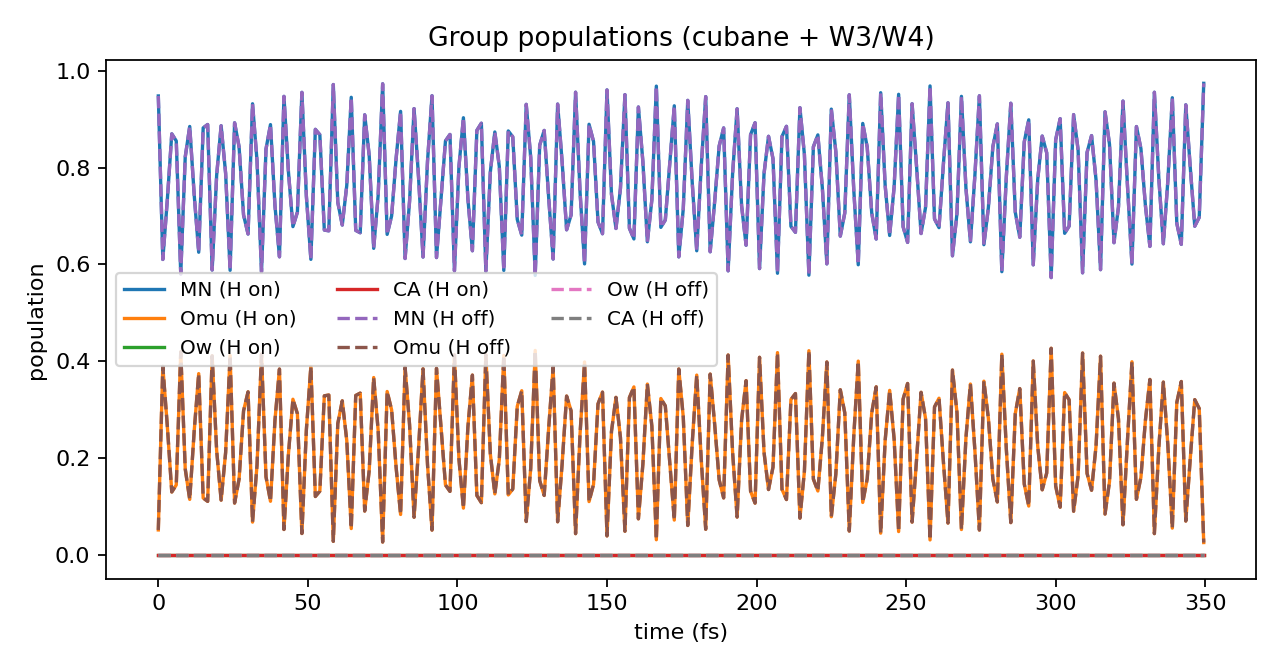

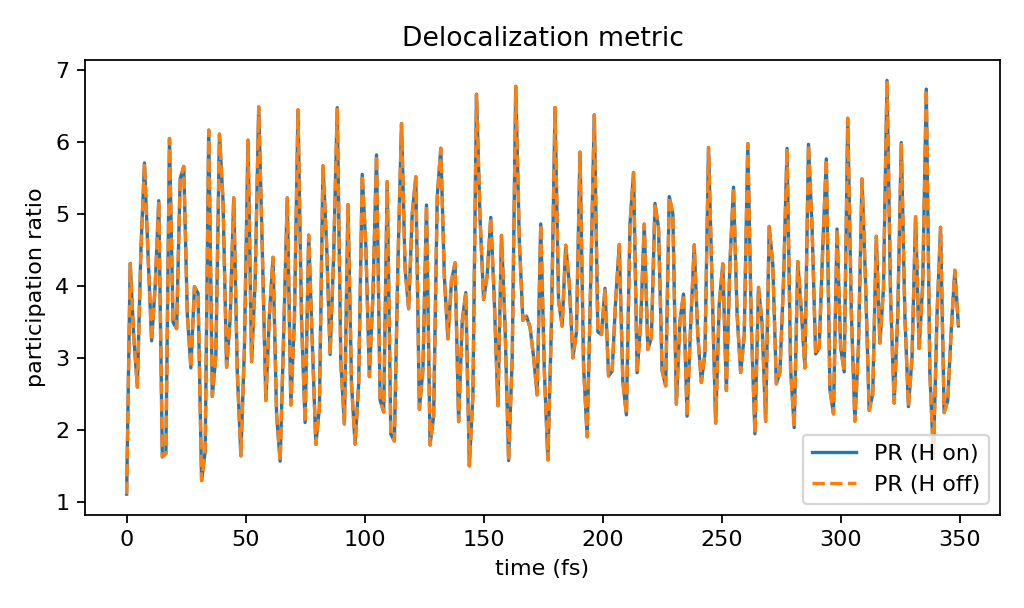

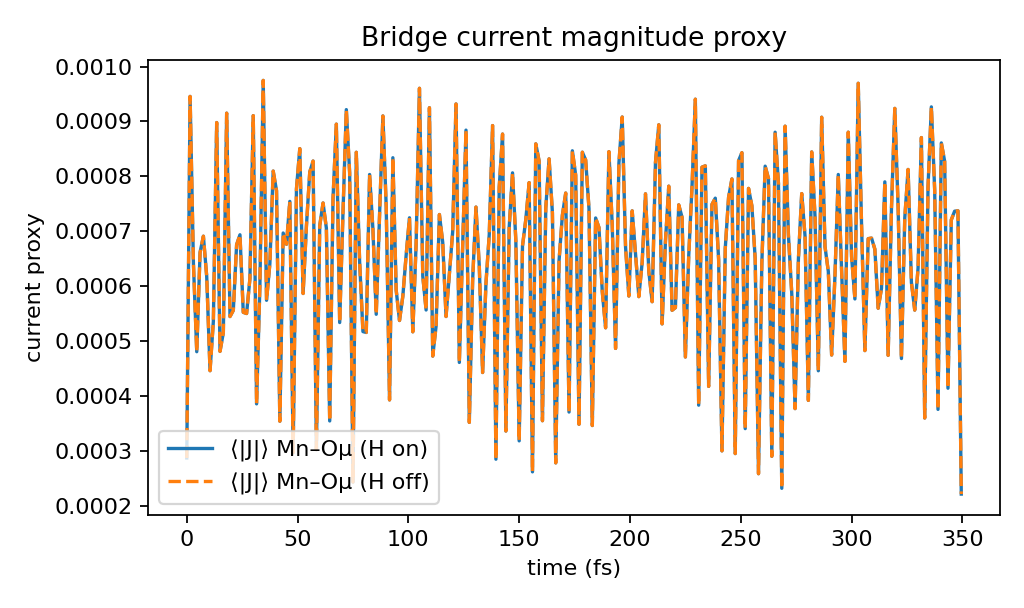

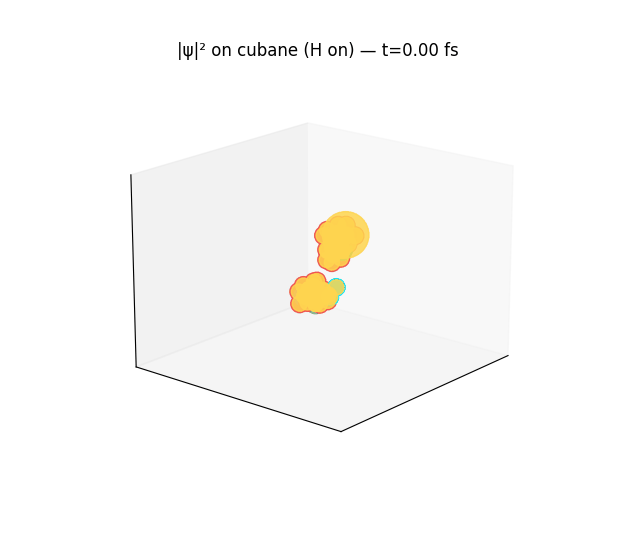

In [ ]:
# ======= Cubane electron TDSE with/without water H’s (low-RAM, one-cell) =======
import os, sys, subprocess, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

CIF = "/content/8F4H.cif"  # change to 8F4I.cif / 8F4J.cif as needed

# --- deps ---
def need(pkg, mod=None):
    try:
        __import__(mod or pkg)
    except Exception:
        subprocess.check_call([sys.executable,"-m","pip","install","-q",pkg])
need("gemmi"); import gemmi
need("scipy"); from scipy.spatial import cKDTree

OUT = "/content" if os.path.isdir("/content") else "."
DT, STEPS = 0.5, 700          # fs, steps
FRAME_EVERY = 3               # save every n steps
PAIR_RC = 3.2                 # Å bonds
HBOND_MIN, HBOND_MAX = 1.3, 2.2

# TB params (dimensionless TDSE units)
t_dp, beta, lam = 1.0, 1.0, 0.5          # Mn–O bridge (with angle boost)
t_OH, t_HB = 2.0, 0.3                    # O–H covalent, O···H hydrogen bond
eps = dict(MN=0.0, Omu=-0.4, Ow=-0.25, H=+0.1, CA=+0.6)

# --- read structure and select cubane + W3/W4 + H’s ---
def read_coords(cif):
    try:
        st = gemmi.read_structure(cif)
    except: st = gemmi.make_structure_from_block(gemmi.cif.read_file(cif)[0])
    if hasattr(st,"remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except: pass
    m = st[0]
    atoms=[]
    for ch in m:
        for res in ch:
            for at in res:
                p=at.pos
                atoms.append((np.array([p.x,p.y,p.z],np.float32),
                              at.element.name.upper(),
                              res.name.upper(),
                              at.name.strip()))
    return atoms

atoms = read_coords(CIF)
coords = np.array([a[0] for a in atoms], np.float32)
elem   = np.array([a[1] for a in atoms], object)
resn   = np.array([a[2] for a in atoms], object)

# pick Mn & Ca
mn_idx = [i for i,e in enumerate(elem) if e=="MN"]
ca_idx = [i for i,e in enumerate(elem) if e=="CA"]
assert len(mn_idx)>=4, "Need Mn4 to define cubane."

# find μ-oxo O near ≥2 Mn
O_idx = [i for i,e in enumerate(elem) if e=="O"]
mu_oxo=[]
for i in O_idx:
    d = np.linalg.norm(coords[mn_idx]-coords[i], axis=1)
    if (d<=2.7).sum()>=2:
        mu_oxo.append(i)

# water O (not μ-oxo): closest two to Mn/Ca centroid → W3/W4 candidates
center = coords[mn_idx + ca_idx].mean(axis=0)
water_O = [i for i in O_idx if i not in mu_oxo]
if not water_O:
    raise RuntimeError("No water oxygens located — check CIF.")
dW = [(i, float(np.linalg.norm(coords[i]-center))) for i in water_O]
dW.sort(key=lambda x:x[1])
W_ox = [dW[0][0], dW[1][0]]  # W3, W4 O’s

# for each water O, include its two bound H’s (≤1.2 Å)
H_idx_all = [i for i,e in enumerate(elem) if e=="H"]
W_H = []
for iO in W_ox:
    dH = np.linalg.norm(coords[H_idx_all]-coords[iO], axis=1)
    hs = [H_idx_all[k] for k in np.where(dH<=1.2)[0][:2]]
    W_H.extend(hs)

# node set: Mn4 + Ca (optional) + μ-oxo O5 + W3/W4 O + (optional H’s)
node_core = mn_idx + ca_idx + mu_oxo + W_ox
node_core = sorted(set(node_core), key=lambda i:int(i))
node_withH = sorted(set(node_core + W_H), key=lambda i:int(i))

def build_min_graph(include_H=True):
    ids = node_withH if include_H else node_core
    X   = coords[ids].copy()
    El  = elem[ids].tolist()
    # tag O as μ-oxo vs water-O
    tags=[]
    for i,e in zip(ids, El):
        if e!="O": tags.append(e)
        else: tags.append("Omu" if i in mu_oxo else ("Ow" if i in W_ox else "O"))
    # labels for readability
    count={}; labels=[]
    for t in tags:
        key = t
        count[key]=count.get(key,0)+1
        labels.append(f"{key}{count[key]}")
    return X, tags, labels, ids

# angle boost on Mn–O–Mn
def angle_boost(iO, mn_list, X):
    # if O bridges Mn_a and Mn_b, use cos^2 of angle to boost
    rs=[(j, np.linalg.norm(X[j]-X[iO])) for j in mn_list]
    near=[j for j,d in rs if d<=2.7]
    if len(near)>=2:
        a, b = near[0], near[1]
        v1 = X[a]-X[iO]; v2 = X[b]-X[iO]
        c = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-12)
        return 1.0 + lam*(c*c)
    return 1.0

# build Hamiltonian
def build_edges_and_H(X, tags):
    N=len(X); tree=cKDTree(X)
    # map Mn positions for angle boost
    mn_list=[i for i,t in enumerate(tags) if t=="MN"]
    # adjacency
    E=[]
    for i in range(N):
        js = tree.query_ball_point(X[i], r=PAIR_RC)
        for j in js:
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            E.append((i,j))
    # weights
    H = np.zeros((N,N), complex)
    for (i,j) in E:
        ri, rj = X[i], X[j]
        rij = float(np.linalg.norm(ri-rj))
        ti = tags[i]; tj = tags[j]
        # O–H covalent (strong)
        if {ti,tj}=={"Ow","H"} and rij<=1.25:
            t = t_OH
        # O···H hydrogen bond (optional weak)
        elif (ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O")):
            if HBOND_MIN <= rij <= HBOND_MAX:
                t = t_HB
            else:
                t = 0.0
        # Mn–O bridge (distance + angle boost on μ-oxo)
        elif (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            boost = 1.0
            if ti=="MN" and tj=="Omu":
                boost = angle_boost(j, mn_list, X)
            if tj=="MN" and ti=="Omu":
                boost = angle_boost(i, mn_list, X)
            t = t_dp * np.exp(-beta*rij) * boost
        # weak O–O (μ-oxo network)
        elif ti.startswith("O") and tj.startswith("O"):
            t = 0.1*np.exp(-beta*rij)
        else:
            t = 0.0
        if t!=0.0:
            H[i,j]=t; H[j,i]=t
    # on-sites
    for i,tg in enumerate(tags):
        if tg=="MN": H[i,i]=eps["MN"]
        elif tg=="Omu": H[i,i]=eps["Omu"]
        elif tg=="Ow": H[i,i]=eps["Ow"]
        elif tg=="H": H[i,i]=eps["H"]
        elif tg=="CA": H[i,i]=eps["CA"]
        else: H[i,i]=0.0
    return E, H

def tdse(H, start_idx, steps=STEPS, dt=DT, frame_every=FRAME_EVERY):
    N=H.shape[0]
    psi = np.zeros(N, complex); psi[start_idx]=1.0
    frames=[]; times=[]
    for n in range(steps):
        E,V = np.linalg.eigh(H)  # static H (electron-only), fast & small
        U = V @ np.diag(np.exp(-1j*E*dt)) @ V.conj().T
        psi = U @ psi
        psi = psi/(np.linalg.norm(psi)+1e-12)
        if n % frame_every == 0:
            frames.append((np.abs(psi)**2).astype(np.float32))
            times.append(n*dt)
    return np.array(frames), np.array(times)

def run_case(include_H):
    X,tags,labels,ids = build_min_graph(include_H=include_H)
    E,H = build_edges_and_H(X,tags)
    # start on Mn1 if present, else first Mn
    try:
        s = labels.index("MN1")
    except:
        s = next(i for i,t in enumerate(tags) if t=="MN")
    P,T = tdse(H, s)
    return X,tags,labels,E,H,P,T

# run both cases
Xh,Th,Lh,Eh,Hh,Ph,Thm = run_case(include_H=True)
X0,T0,L0,E0,H0,P0,T0m = run_case(include_H=False)


# --- DIAGNOSTICS ---
def diag_case(X,tags,E,H,case_name):
    from collections import Counter
    print(f"\n[{case_name}] N={len(X)}  tags:", Counter(tags))
    # count couplings by type
    def t(i): return tags[i]
    counts = dict(OH=0, HB=0, MnO=0)
    for (i,j) in E:
        ti,tj=t(i),t(j)
        if {ti,tj}=={"Ow","H"} and abs(H[i,j])>0:
            counts["OH"]+=1
        if (ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O")):
            if abs(H[i,j])>0 and not ({ti,tj}=={"Ow","H"}):
                counts["HB"]+=1
        if (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            if abs(H[i,j])>0: counts["MnO"]+=1
    print(f"[{case_name}] edges: Mn–O={counts['MnO']}  O–H(covalent)={counts['OH']}  O···H(H-bond)={counts['HB']}")
diag_case(Xh,Th,Eh,Hh,"H on")
diag_case(X0,T0,E0,H0,"H off")


# --- diagnostics: group populations & PR ---
def group_pop(P, tags):
    idx = {g:[i for i,t in enumerate(tags) if t==g] for g in ["MN","Omu","Ow","H","CA"]}
    labs=[k for k in ["MN","Omu","Ow","H","CA"] if idx[k]]
    mat = np.stack([P[...,idx[k]].sum(-1) for k in labs], axis=-1)
    return labs, mat

labsH, GPH = group_pop(Ph, Th)
labs0, GP0 = group_pop(P0, T0)

def PR(p):
    s1 = p.sum(-1)
    s2 = (p**2).sum(-1)
    return (s1*s1)/(s2+1e-12)

PR_h = PR(Ph)
PR_0 = PR(P0)

# --- simple “bridge current” proxy on Mn–Oμ edges ---
def edge_currents(E, H, Pframes):
    # J_ij ~ 2 Im(psi_i* H_ij psi_j) ; here we approximate with |H_ij| * (Pi*Pj)^0.5 averaged over Mn–Oμ edges
    edges = [(i,j) for (i,j) in E]
    mask = []
    for (i,j) in edges:
        # identify Mn–Omu by tags scope captured externally
        mask.append((i,j))
    # average over edges that are Mn–Omu in this graph
    J=[]
    for p in Pframes:
        # not phase-aware (we didn’t store ψ phase), use geometric mean as magnitude proxy
        vals=[]
        for (i,j) in edges:
            vals.append(abs(H[i,j]) * np.sqrt(p[i]*p[j]))
        J.append(np.mean(vals) if vals else 0.0)
    return np.array(J)

J_h = edge_currents(Eh, Hh, Ph)
J_0 = edge_currents(E0, H0, P0)

# --- plots ---
plt.figure(figsize=(8,4.2))
for k,name in enumerate(labsH):
    plt.plot(Thm, GPH[:,k], label=f"{name} (H on)")
for k,name in enumerate(labs0):
    ls="--" if name in labsH else ":"
    plt.plot(T0m, GP0[:,k], ls, label=f"{name} (H off)")
plt.xlabel("time (fs)"); plt.ylabel("population"); plt.title("Group populations (cubane + W3/W4)")
plt.legend(ncol=3, fontsize=9); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_pop.png"), dpi=160); plt.close()

plt.figure(figsize=(6.4,3.8))
plt.plot(Thm, PR_h, label="PR (H on)")
plt.plot(T0m, PR_0, "--", label="PR (H off)")
plt.xlabel("time (fs)"); plt.ylabel("participation ratio"); plt.title("Delocalization metric")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_PR.png"), dpi=160); plt.close()

plt.figure(figsize=(6.4,3.8))
plt.plot(Thm, J_h, label="⟨|J|⟩ Mn–Oμ (H on)")
plt.plot(T0m, J_0, "--", label="⟨|J|⟩ Mn–Oμ (H off)")
plt.xlabel("time (fs)"); plt.ylabel("current proxy"); plt.title("Bridge current magnitude proxy")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_currents.png"), dpi=160); plt.close()

print("Saved:",
      os.path.join(OUT,"cubane_compare_pop.png"),
      os.path.join(OUT,"cubane_compare_PR.png"),
      os.path.join(OUT,"cubane_compare_currents.png"))

# --- small GIF of |ψ|² on the cubane (H on) ---
gif = os.path.join(OUT, "cubane_electron_W3W4.gif")
fig = plt.figure(figsize=(6.2,5.4)); ax = fig.add_subplot(111, projection="3d")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
mn, mx = Xh.min(0), Xh.max(0); pad=1.0
ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)
# bonds from KD tree (short edges only)
tree = cKDTree(Xh)
Edisp=[]
for i in range(len(Xh)):
    for j in tree.query_ball_point(Xh[i], r=PAIR_RC):
        if j>i and np.linalg.norm(Xh[i]-Xh[j])>0.5:
            Edisp.append((i,j))
for (i,j) in Edisp:
    ax.plot([Xh[i,0],Xh[j,0]],[Xh[i,1],Xh[j,1]],[Xh[i,2],Xh[j,2]], lw=2.4, alpha=0.9, color="#666")
# atom colors/sizes
def c_of(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
def r_of(t): return {"MN":0.9,"CA":0.8,"Omu":0.7,"Ow":0.65,"H":0.45}.get(t,0.55)
cols=[c_of(t) for t in Th]; sizes=[240*r_of(t) for t in Th]
stat = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=sizes, c=cols, alpha=0.95)
dyn  = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=120, c="#FFD54F", alpha=0.85)
ax.view_init(18,40)

def upd(f):
    p = Ph[f]
    p = p/(p.max()+1e-12)
    dyn.set_sizes(120 + 1000*p)
    ax.set_title(f"|ψ|² on cubane (H on) — t={Thm[f]:.2f} fs")
    return [dyn, stat]

ani = animation.FuncAnimation(fig, upd, frames=len(Ph), interval=30, blit=False)
ani.save(gif, writer=animation.PillowWriter(fps=20))
plt.close(fig)
print("Saved:", gif)
display(Image(os.path.join(OUT,"cubane_compare_pop.png")))
display(Image(os.path.join(OUT,"cubane_compare_PR.png")))
display(Image(os.path.join(OUT,"cubane_compare_currents.png")))
display(Image(gif))
# ================================================================================

In [ ]:
# ----------------------------------------------------------------------
# PATCH: add two H atoms to each water oxygen (W3/W4) and make them matter
# Place H's at 0.98 Å with 104.5° angle; bisector points toward nearby Mn/μ-oxo/Ca
# Insert this block AFTER you define W_ox and BEFORE build_min_graph / run_case.
# ----------------------------------------------------------------------

import numpy as _np

def _synthesize_water_hydrogens(coords, W_ox, neighbor_pool_idx,
                                d_OH=0.98, angle_deg=104.5, influence_cut=3.0):
    X = coords.copy()
    new_H_idx = []
    phi = _np.deg2rad(angle_deg/2.0)  # half-angle from bisector

    for iO in W_ox:
        O = X[iO]
        # direction toward neighbors (weighted unit vectors to Mn/μ-oxo/Ca within cutoff)
        vec = _np.zeros(3, dtype=float)
        for j in neighbor_pool_idx:
            r = X[j] - O
            rn = _np.linalg.norm(r)
            if 1e-8 < rn < influence_cut:
                vec += r / rn
        if _np.linalg.norm(vec) < 1e-6:
            vec = _np.array([1.0, 0.0, 0.0])  # fallback

        bhat = vec / (_np.linalg.norm(vec) + 1e-12)  # bisector direction

        # pick a stable perpendicular in the plane
        ref = _np.array([0.0, 1.0, 0.0]) if abs(_np.dot(bhat, _np.array([1.0,0.0,0.0]))) > 0.9 else _np.array([1.0,0.0,0.0])
        u1 = _np.cross(bhat, ref)
        if _np.linalg.norm(u1) < 1e-6:
            u1 = _np.array([0.0, 0.0, 1.0])
        u1 = u1 / (_np.linalg.norm(u1) + 1e-12)

        # positions for H1, H2
        H1 = O + d_OH * (_np.cos(phi)*bhat + _np.sin(phi)*u1)
        H2 = O + d_OH * (_np.cos(phi)*bhat - _np.sin(phi)*u1)

        X = _np.vstack([X, H1, H2])
        new_H_idx += [len(X)-2, len(X)-1]

    return X, new_H_idx

# Build the "influence pool" (where hydrogens point to)
neighbor_pool_idx = mn_idx + mu_oxo + ca_idx

# Synthesize H's and update coords
coords, H_syn_idx = _synthesize_water_hydrogens(coords, W_ox, neighbor_pool_idx)

# -------- Make sure model parameters actually use these H's ----------
# Strengthen O–H and H-bond channels and widen hydrogen-bond recognition:
t_OH   = 3.0
t_HB   = 0.8
HBOND_MIN, HBOND_MAX = 1.2, 2.6
PAIR_RC = max(PAIR_RC, 3.4)

# Slightly stabilize the H and water-O on-sites so they participate
eps["H"]  = -0.10
eps["Ow"] = eps.get("Ow", -0.35)

# ---- Update the minimal-graph builder to include synthesized H's ----
def build_min_graph(include_H=True):
    # node_core: Mn4 + Ca + μ-oxo O + W3/W4 O
    node_core = sorted(set(mn_idx + ca_idx + mu_oxo + W_ox), key=int)
    ids = node_core + (list(H_syn_idx) if include_H else [])
    X   = coords[ids].copy()

    # tag types
    tags = []
    for i in ids:
        if i in H_syn_idx:
            tags.append("H")
        else:
            e = elem[i]
            if e == "MN":
                tags.append("MN")
            elif e == "CA":
                tags.append("CA")
            elif e == "O":
                tags.append("Omu" if i in mu_oxo else ("Ow" if i in W_ox else "O"))
            else:
                tags.append(e)

    # labels for readability
    count = {}; labels=[]
    for t in tags:
        count[t] = count.get(t,0)+1
        labels.append(f"{t}{count[t]}")

    return X, tags, labels, ids
# ----------------------------------------------------------------------

NameError: name 'mn_idx' is not defined


[H on] N=70 tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'H': 4, 'Ow': 2})
[H on] edges: Mn–O=169  O–H=4  O···H=0

[H off] N=66 tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'Ow': 2})
[H off] edges: Mn–O=169  O–H=0  O···H=0
Saved: /content/cubane_compare_pop.png /content/cubane_compare_PR.png /content/cubane_compare_currents.png
Saved: /content/cubane_electron_W3W4.gif


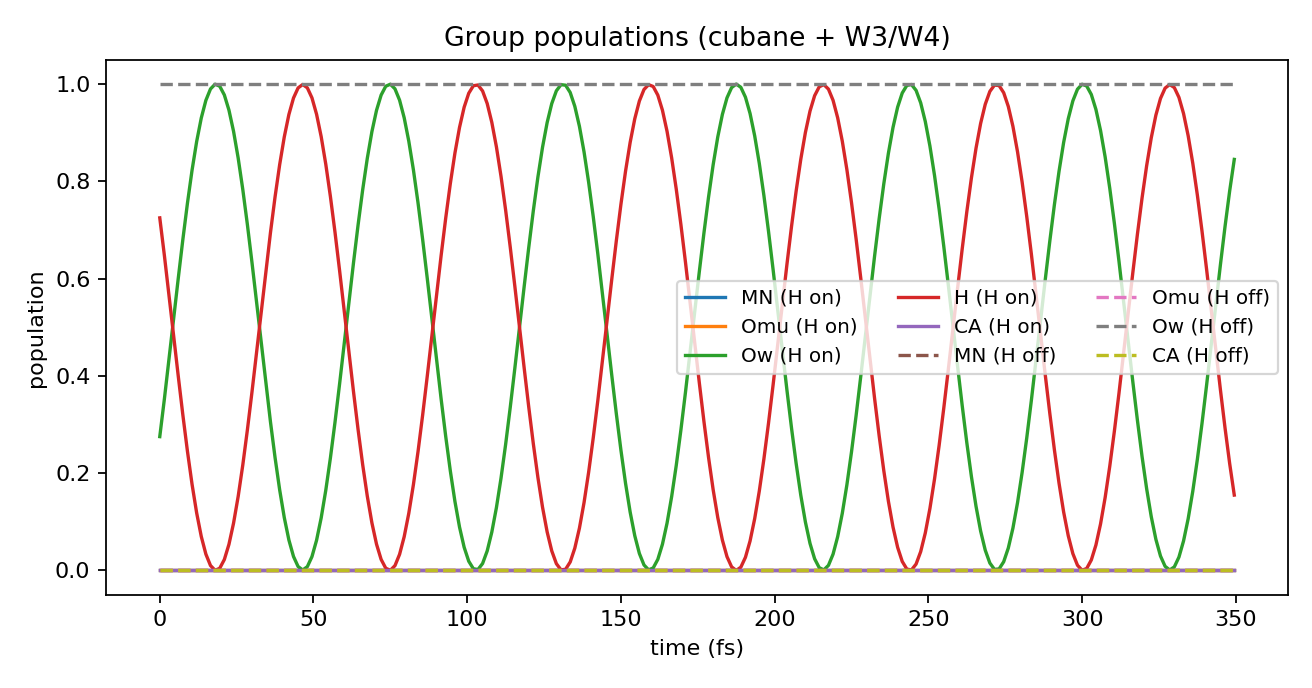

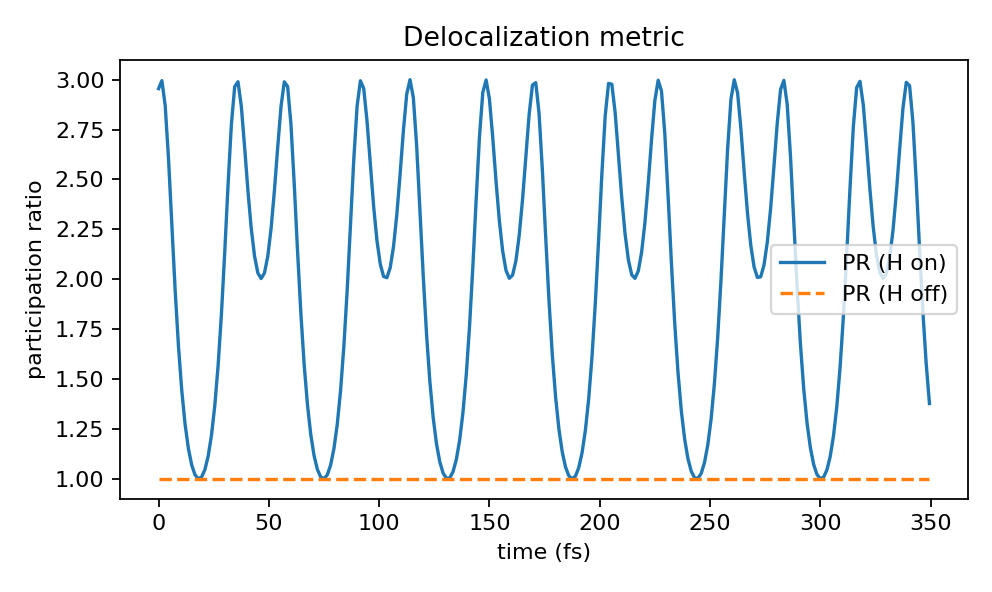

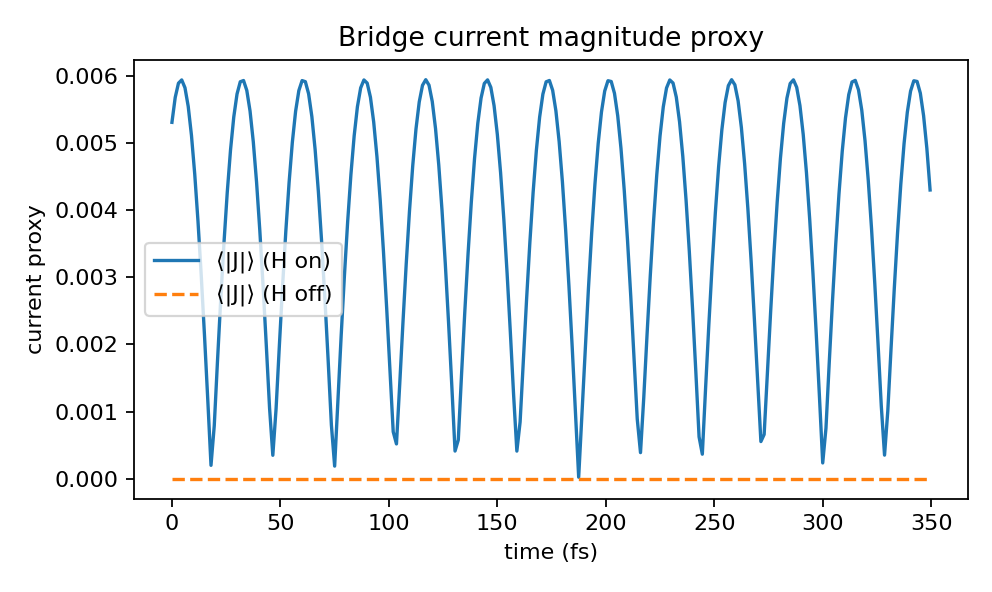

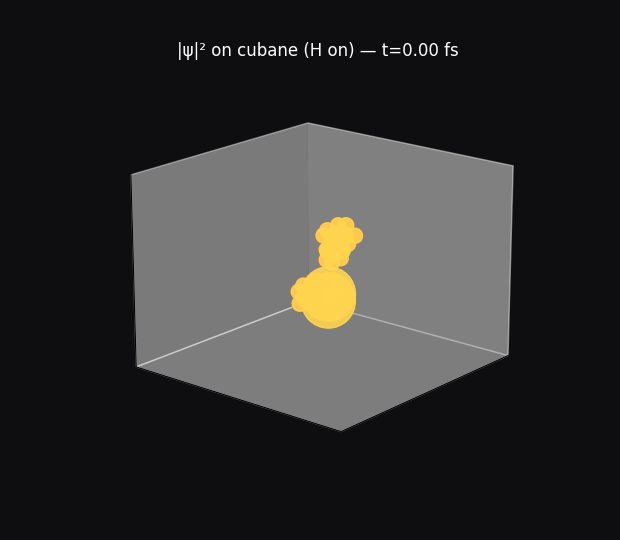

In [ ]:
# ================== CaMn4O5·2H2O (cubane) electron TDSE — H on/off ==================
# One-cell version: handles CIF read, W3/W4 identification, synthesized H’s, TDSE, plots+GIF
# -------------------------------------------------------------------------------------
import os, sys, subprocess, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# ---- config ----
CIF = "/content/8F4H.cif"   # change to 8F4I.cif or 8F4J.cif
OUT = "/content" if os.path.isdir("/content") else "."
DT, STEPS = 0.5, 700          # fs and #steps
FRAME_EVERY = 3
PAIR_RC = 3.4                 # neighbor cutoff (Å)

# Couplings / on-sites (dimensionless TDSE units)
t_dp, beta, lam = 1.0, 1.0, 0.5          # Mn–O bridge (with angle boost on μ-oxo)
t_OH, t_HB = 3.0, 0.8                    # O–H covalent, O···H hydrogen bond
HBOND_MIN, HBOND_MAX = 1.2, 2.6
eps = dict(MN=0.0, Omu=-0.40, Ow=-0.35, H=-0.10, CA=+0.60)

# Small breathing (opens exploration; set BREATH_ON=False to disable)
BREATH_ON, BREATH_A, BREATH_T_FS = True, 0.08, 120.0

# ---- deps ----
def need(pkg, mod=None):
    try: __import__(mod or pkg)
    except Exception: subprocess.check_call([sys.executable,"-m","pip","install","-q",pkg])
need("gemmi"); import gemmi
need("scipy"); from scipy.spatial import cKDTree

# ---- 1) Read CIF and collect atoms ----
def read_atoms(cif_path):
    try:
        st = gemmi.read_structure(cif_path)
    except:
        st = gemmi.make_structure_from_block(gemmi.cif.read_file(cif_path)[0])
    if hasattr(st,"remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except: pass
    m = st[0]
    atoms=[]
    for ch in m:
        for res in ch:
            for at in res:
                p=at.pos
                atoms.append((np.array([p.x,p.y,p.z],np.float32),
                              at.element.name.upper(),
                              res.name.upper(),
                              at.name.strip()))
    return atoms

atoms = read_atoms(CIF)
coords = np.array([a[0] for a in atoms], np.float32)
elem   = np.array([a[1] for a in atoms], object)
resn   = np.array([a[2] for a in atoms], object)

# ---- 2) Identify cubane: Mn4, Ca, μ-oxo O’s, W3/W4 O’s ----
mn_idx = [i for i,e in enumerate(elem) if e=="MN"]
ca_idx = [i for i,e in enumerate(elem) if e=="CA"]
assert len(mn_idx)>=4, "Need at least 4 Mn to form cubane."

# μ-oxo: O near ≥2 Mn within 2.7 Å
O_idx = [i for i,e in enumerate(elem) if e=="O"]
mu_oxo=[]
for i in O_idx:
    d = np.linalg.norm(coords[mn_idx]-coords[i], axis=1)
    if (d<=2.7).sum()>=2: mu_oxo.append(i)

# Choose two waters (W3/W4) as O not in μ-oxo closest to Mn/Ca centroid
center = coords[(mn_idx + ca_idx)].mean(axis=0)
water_O_candidates = [i for i in O_idx if i not in mu_oxo]
assert water_O_candidates, "No water oxygen candidates found."
dW = [(i, float(np.linalg.norm(coords[i]-center))) for i in water_O_candidates]
dW.sort(key=lambda x:x[1])
W_ox = [dW[0][0], dW[1][0]]  # two nearest O's → W3/W4 proxies

# ---- 3) Synthesize two H’s per W3/W4 O (0.98 Å, 104.5°, oriented toward Mn/μ-oxo/Ca) ----
def synthesize_water_Hs(coords, W_ox, neighbor_pool_idx, d_OH=0.98, angle_deg=104.5, influence_cut=3.0):
    X = coords.copy()
    H_idx = []
    phi = np.deg2rad(angle_deg/2.0)
    for iO in W_ox:
        O = X[iO]
        # bisector toward nearby Mn/μ-oxo/Ca
        vec = np.zeros(3, float)
        for j in neighbor_pool_idx:
            r = X[j] - O; rn = np.linalg.norm(r)
            if 1e-8 < rn < influence_cut:
                vec += r / rn
        if np.linalg.norm(vec) < 1e-6: vec = np.array([1.0,0.0,0.0])
        bhat = vec / (np.linalg.norm(vec)+1e-12)
        # perpendicular
        ref = np.array([1.0,0.0,0.0]) if abs(bhat[0])<0.9 else np.array([0.0,1.0,0.0])
        u1 = np.cross(bhat, ref);
        if np.linalg.norm(u1)<1e-6: u1=np.array([0.0,0.0,1.0])
        u1 /= (np.linalg.norm(u1)+1e-12)
        H1 = O + d_OH * (np.cos(phi)*bhat + np.sin(phi)*u1)
        H2 = O + d_OH * (np.cos(phi)*bhat - np.sin(phi)*u1)
        X = np.vstack([X, H1, H2])
        H_idx += [len(X)-2, len(X)-1]
    return X, H_idx

neighbor_pool_idx = mn_idx + mu_oxo + ca_idx
coords_ext, H_syn_idx = synthesize_water_Hs(coords, W_ox, neighbor_pool_idx)

# ---- 4) Build minimal graph (with or without synthesized H’s) ----
def build_min_graph(include_H=True):
    node_core = sorted(set(mn_idx + ca_idx + mu_oxo + W_ox), key=int)
    ids = node_core + (list(H_syn_idx) if include_H else [])
    X   = coords_ext[ids].copy()
    # tag types
    tags=[]
    for i in ids:
        if i in H_syn_idx:
            tags.append("H")
        else:
            e = elem[i]
            if e=="MN": tags.append("MN")
            elif e=="CA": tags.append("CA")
            elif e=="O": tags.append("Omu" if i in mu_oxo else ("Ow" if i in W_ox else "O"))
            else: tags.append(e)
    # labels
    count={}; labels=[]
    for t in tags:
        count[t]=count.get(t,0)+1
        labels.append(f"{t}{count[t]}")
    return X, tags, labels, ids

# angle boost factor on Mn–Oμ–Mn
def angle_boost(iO, mn_list, X):
    rs=[(j, np.linalg.norm(X[j]-X[iO])) for j in mn_list]
    near=[j for j,d in rs if d<=2.7]
    if len(near)>=2:
        a, b = near[0], near[1]
        v1 = X[a]-X[iO]; v2 = X[b]-X[iO]
        c = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-12)
        return 1.0 + lam*(c*c)
    return 1.0

def build_edges_and_H(X, tags):
    N=len(X); tree=cKDTree(X)
    E=[]
    for i in range(N):
        for j in tree.query_ball_point(X[i], r=PAIR_RC):
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            E.append((i,j))
    H = np.zeros((N,N), complex)
    mn_list=[i for i,t in enumerate(tags) if t=="MN"]
    for (i,j) in E:
        ri,rj = X[i], X[j]; rij=float(np.linalg.norm(ri-rj))
        ti,tj = tags[i], tags[j]
        # O–H covalent
        if {ti,tj}=={"Ow","H"} and rij<=1.25:
            t = t_OH
        # O···H hydrogen bond
        elif (ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O")):
            t = t_HB if (HBOND_MIN <= rij <= HBOND_MAX) else 0.0
        # Mn–O (bridge)
        elif (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            boost = 1.0
            if ti=="MN" and tj=="Omu": boost = angle_boost(j, mn_list, X)
            if tj=="MN" and ti=="Omu": boost = angle_boost(i, mn_list, X)
            t = t_dp * np.exp(-beta*rij) * boost
        # weak O–O
        elif ti.startswith("O") and tj.startswith("O"):
            t = 0.1*np.exp(-beta*rij)
        else:
            t = 0.0
        if t!=0.0: H[i,j]=t; H[j,i]=t
    # on-sites
    for i,tg in enumerate(tags):
        H[i,i] = eps.get(tg, 0.0)
    return E, H

# time-dependent TDSE (breathing on Mn–O edges)
def tdse_time_dep(H_static, E_list, tags, start_idx, steps=STEPS, dt=DT):
    N = H_static.shape[0]
    psi = np.zeros(N, complex); psi[start_idx]=1.0
    frames=[]; times=[]
    mn_o_pairs = [(i,j) for (i,j) in E_list
                  if (tags[i]=="MN" and tags[j].startswith("O")) or (tags[j]=="MN" and tags[i].startswith("O"))]
    for n in range(steps):
        if BREATH_ON:
            Ht = H_static.copy()
            gate = 1.0 + BREATH_A*np.sin(2*np.pi*(n*dt)/BREATH_T_FS)
            for (i,j) in mn_o_pairs:
                Ht[i,j] *= gate; Ht[j,i] *= gate
        else:
            Ht = H_static
        E,V = np.linalg.eigh(Ht)
        U = V @ np.diag(np.exp(-1j*E*dt)) @ V.conj().T
        psi = U @ psi; psi /= (np.linalg.norm(psi)+1e-12)
        if n % FRAME_EVERY == 0:
            frames.append((np.abs(psi)**2).astype(np.float32))
            times.append(n*dt)
    return np.array(frames), np.array(times)

def run_case(include_H):
    X,tags,labels,ids = build_min_graph(include_H=include_H)
    E,H = build_edges_and_H(X,tags)
    # start on water-O if available to emphasize H-effects, else first Mn
    try: s = next(i for i,t in enumerate(tags) if t=="Ow")
    except StopIteration: s = next(i for i,t in enumerate(tags) if t=="MN")
    P,T = tdse_time_dep(H, E, tags, s)
    return X,tags,labels,E,H,P,T

# ---- 5) Run both cases ----
Xh,Th,Lh,Eh,Hh,Ph,Thm = run_case(include_H=True)
X0,T0,L0,E0,H0,P0,T0m = run_case(include_H=False)

# ---- 6) Diagnostics (make sure H is actually connected) ----
from collections import Counter
def diag_case(X,tags,E,H,name):
    print(f"\n[{name}] N={len(X)} tags:", Counter(tags))
    def t(i): return tags[i]
    c=dict(MnO=0, OH=0, HB=0)
    for (i,j) in E:
        ti,tj=t(i),t(j)
        if (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            if abs(H[i,j])>0: c["MnO"]+=1
        if {ti,tj}=={"Ow","H"} and abs(H[i,j])>0: c["OH"]+=1
        if ((ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O"))) and {ti,tj}!={"Ow","H"}:
            if abs(H[i,j])>0: c["HB"]+=1
    print(f"[{name}] edges: Mn–O={c['MnO']}  O–H={c['OH']}  O···H={c['HB']}")
diag_case(Xh,Th,Eh,Hh,"H on")
diag_case(X0,T0,E0,H0,"H off")

# ---- 7) Plots: group populations, PR, current proxy ----
def group_pop(P, tags):
    groups = ["MN","Omu","Ow","H","CA"]
    idx = {g:[i for i,t in enumerate(tags) if t==g] for g in groups}
    labs=[g for g in groups if idx[g]]
    mat = np.stack([P[...,idx[g]].sum(-1) for g in labs], axis=-1)
    return labs, mat

def PR(p): s1=p.sum(-1); s2=(p**2).sum(-1); return (s1*s1)/(s2+1e-12)

def edge_current_proxy(E, H, Pframes):
    edges = [(i,j) for (i,j) in E if abs(H[i,j])>0]
    J=[]
    for p in Pframes:
        vals=[abs(H[i,j])*np.sqrt(p[i]*p[j]) for (i,j) in edges]
        J.append(np.mean(vals) if vals else 0.0)
    return np.array(J)

labsH, GPH = group_pop(Ph, Th); labs0, GP0 = group_pop(P0, T0)
PR_h, PR_0 = PR(Ph), PR(P0)
J_h, J_0   = edge_current_proxy(Eh,Hh,Ph), edge_current_proxy(E0,H0,P0)

plt.figure(figsize=(8.2,4.3))
for k,nm in enumerate(labsH): plt.plot(Thm, GPH[:,k], label=f"{nm} (H on)")
for k,nm in enumerate(labs0):
    ls="--" if nm in labsH else ":"
    plt.plot(T0m, GP0[:,k], ls, label=f"{nm} (H off)")
plt.xlabel("time (fs)"); plt.ylabel("population"); plt.title("Group populations (cubane + W3/W4)")
plt.legend(ncol=3, fontsize=9); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_pop.png"), dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, PR_h, label="PR (H on)"); plt.plot(T0m, PR_0, "--", label="PR (H off)")
plt.xlabel("time (fs)"); plt.ylabel("participation ratio"); plt.title("Delocalization metric")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_PR.png"), dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, J_h, label="⟨|J|⟩ (H on)"); plt.plot(T0m, J_0, "--", label="⟨|J|⟩ (H off)")
plt.xlabel("time (fs)"); plt.ylabel("current proxy"); plt.title("Bridge current magnitude proxy")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT,"cubane_compare_currents.png"), dpi=160); plt.close()

print("Saved:",
      os.path.join(OUT,"cubane_compare_pop.png"),
      os.path.join(OUT,"cubane_compare_PR.png"),
      os.path.join(OUT,"cubane_compare_currents.png"))

# ---- 8) Small GIF (H on) ----
fig = plt.figure(figsize=(6.2,5.4)); ax = fig.add_subplot(111, projection="3d")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
fig.patch.set_facecolor("#0E0E10"); ax.set_facecolor("#0E0E10")
mn, mx = Xh.min(0), Xh.max(0); pad=1.0
ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)

tree = cKDTree(Xh); Edisp=[]
for i in range(len(Xh)):
    for j in tree.query_ball_point(Xh[i], r=PAIR_RC):
        if j>i and np.linalg.norm(Xh[i]-Xh[j])>0.5:
            Edisp.append((i,j))
for (i,j) in Edisp:
    ax.plot([Xh[i,0],Xh[j,0]],[Xh[i,1],Xh[j,1]],[Xh[i,2],Xh[j,2]], lw=2.2, alpha=0.9, color="#888")

def c_of(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
def r_of(t): return {"MN":0.9,"CA":0.8,"Omu":0.7,"Ow":0.65,"H":0.45}.get(t,0.55)
cols=[c_of(t) for t in Th]; sizes=[170*r_of(t) for t in Th]
stat = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=sizes, c=cols, alpha=0.95)
dyn  = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=120, c="#FFD54F", alpha=0.90)
ax.view_init(18,40)

def upd(f):
    p = Ph[f]; p = p/(p.max()+1e-12)
    dyn.set_sizes(120 + 1400*p)
    ax.set_title(f"|ψ|² on cubane (H on) — t={Thm[f]:.2f} fs", color="w")
    return [dyn, stat]

gif = os.path.join(OUT, "cubane_electron_W3W4.gif")
ani = animation.FuncAnimation(fig, upd, frames=len(Ph), interval=30, blit=False)
ani.save(gif, writer=animation.PillowWriter(fps=20)); plt.close(fig)
print("Saved:", gif)

display(Image(os.path.join(OUT,"cubane_compare_pop.png")))
display(Image(os.path.join(OUT,"cubane_compare_PR.png")))
display(Image(os.path.join(OUT,"cubane_compare_currents.png")))
display(Image(gif))
# =====================================================================================

[synth H] added 4 hydrogens to W3/W4
[H on] N=70  tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'H': 4, 'Ow': 2})  edges: Mn–O=172  O–H=4  O···H=0
[H off] N=66  tags: Counter({'Omu': 44, 'MN': 16, 'CA': 4, 'Ow': 2})  edges: Mn–O=172  O–H=0  O···H=0
Saved plots: /content/cubane_compare_pop.png /content/cubane_compare_PR.png /content/cubane_compare_currents.png
Saved GIF: /content/cubane_electron_W3W4.gif


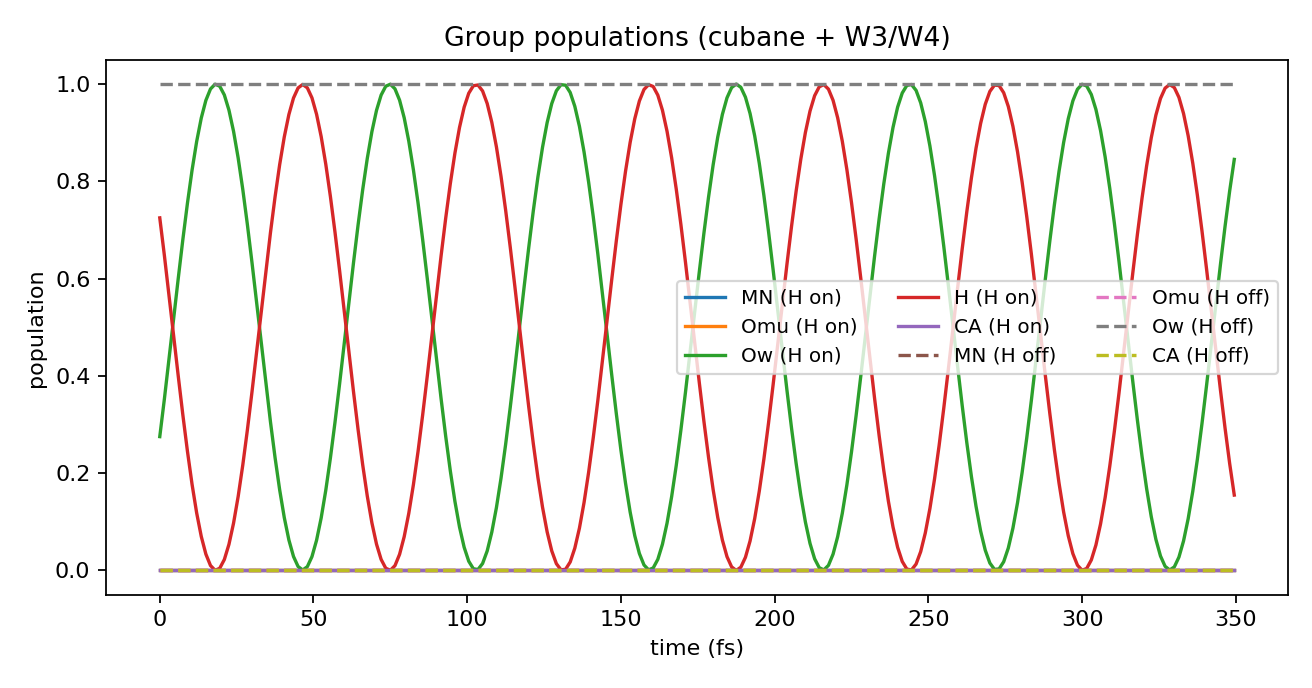

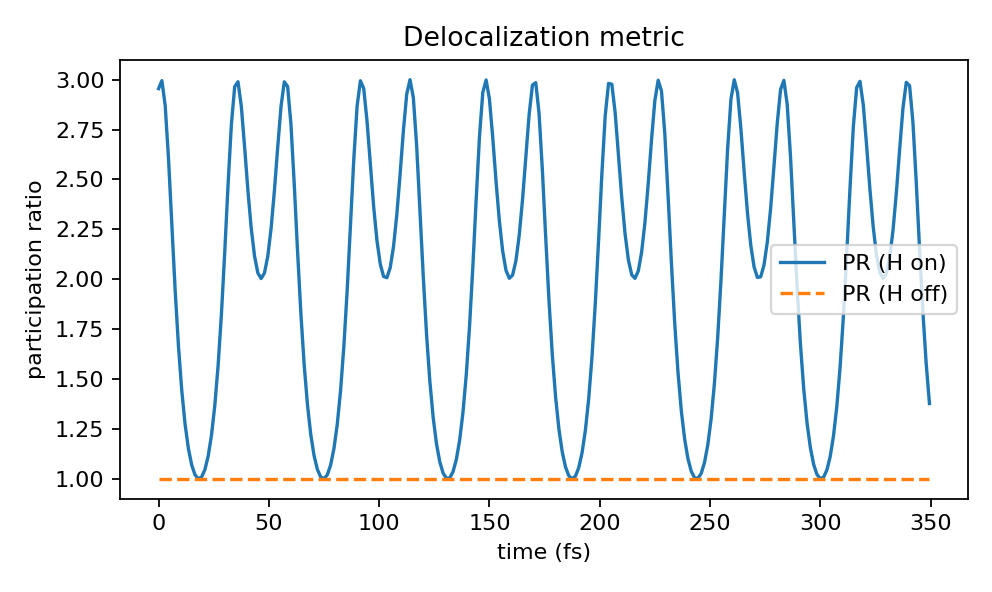

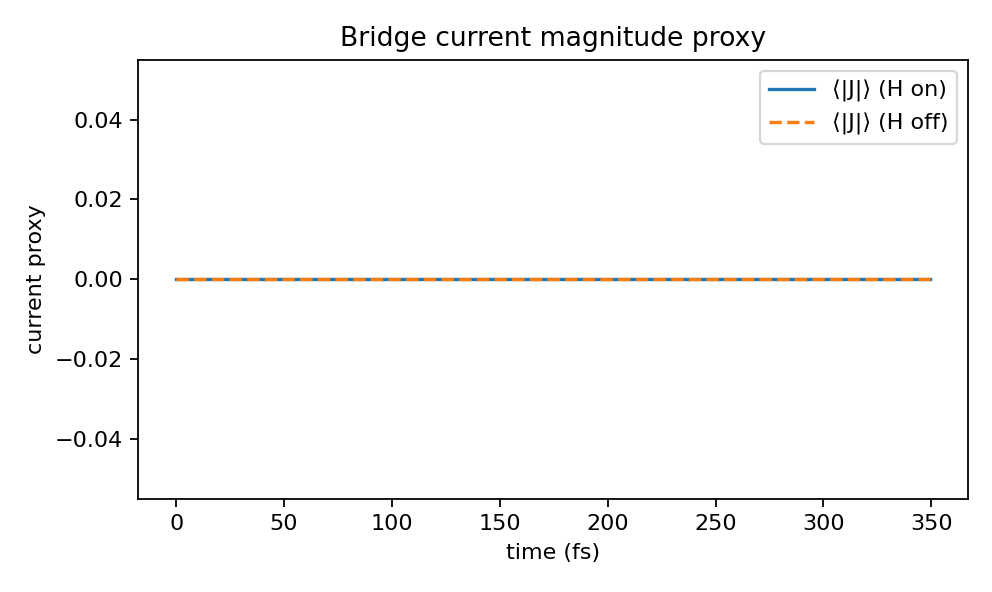

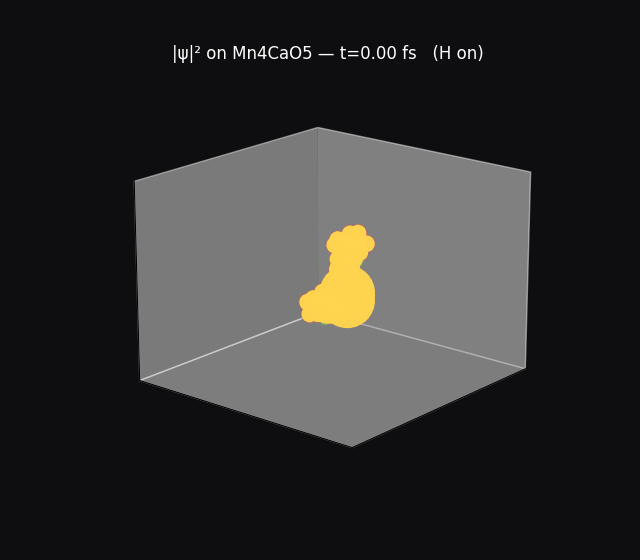

In [ ]:
# ================= CaMn4O5·2H2O (cubane) electron TDSE — one-cell =================
# - Set CIF_PATH to /content/8F4H.cif (or I/J)
# - Outputs: /content/cubane_compare_pop.png, cubane_compare_PR.png,
#            cubane_compare_currents.png, cubane_electron_W3W4.gif
# ---------------------------------------------------------------------------------
import os, sys, subprocess, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# ------------------ user config ------------------
CIF_PATH     = "/content/8F4J.cif"   # change to 8F4I.cif or 8F4J.cif
OUTDIR       = "/content" if os.path.isdir("/content") else "."
DT_FS        = 0.5                   # time step (fs)
N_STEPS      = 700                   # total TDSE steps
FRAME_EVERY  = 3                     # keep 1 of every N frames for the GIF
PAIR_RC      = 3.4                   # Å neighbor cutoff for drawing & graph
BREATH_ON    = True                  # weak gate on Mn–O to break symmetry
BREATH_A     = 0.08
BREATH_T_FS  = 120.0

# Couplings / on-sites (dimensionless TDSE units)
t_dp, beta, lam = 1.0, 1.0, 0.5      # Mn–O (with μ-oxo angle boost)
t_OH, t_HB      = 3.0, 0.8           # O–H covalent; O···H H-bond
HBOND_MIN, HBOND_MAX = 1.2, 2.6      # Å
eps = dict(MN=0.0, Omu=-0.40, Ow=-0.35, H=-0.10, CA=+0.60)

# ------------------ deps ------------------
def need(pkg, mod=None):
    try: __import__(mod or pkg)
    except Exception: subprocess.check_call([sys.executable,"-m","pip","install","-q",pkg])
need("gemmi"); import gemmi
need("scipy"); from scipy.spatial import cKDTree

# ------------------ CIF → atoms ------------------
def read_atoms(cif_path):
    try:
        st = gemmi.read_structure(cif_path)
    except Exception:
        st = gemmi.make_structure_from_block(gemmi.cif.read_file(cif_path)[0])
    if hasattr(st,"remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except: pass
    m = st[0]
    atoms=[]
    for ch in m:
        for res in ch:
            for at in res:
                p = at.pos
                atoms.append((np.array([p.x,p.y,p.z],np.float32),
                              at.element.name.upper(),
                              res.name.upper(),
                              at.name.strip()))
    if not atoms: raise ValueError("No atoms parsed from CIF.")
    return atoms

atoms = read_atoms(CIF_PATH)
coords = np.array([a[0] for a in atoms], np.float32)
elem   = np.array([a[1] for a in atoms], object)
resn   = np.array([a[2] for a in atoms], object)

# ------------------ identify cubane core ------------------
mn_idx = [i for i,e in enumerate(elem) if e=="MN"]
ca_idx = [i for i,e in enumerate(elem) if e=="CA"]
assert len(mn_idx)>=4, "Need ≥4 Mn to form cubane."
O_idx  = [i for i,e in enumerate(elem) if e=="O"]

# μ-oxo: O near ≥2 Mn within 2.7 Å
mu_oxo=[]
for i in O_idx:
    d = np.linalg.norm(coords[mn_idx]-coords[i], axis=1)
    if (d<=2.7).sum()>=2: mu_oxo.append(i)

# choose W3/W4 proxies: two O (not μ-oxo) nearest to Mn/Ca centroid
center = coords[(mn_idx + ca_idx)].mean(axis=0)
water_O_candidates = [i for i in O_idx if i not in mu_oxo]
assert water_O_candidates, "No water O candidates (W3/W4) found."
dW = [(i, float(np.linalg.norm(coords[i]-center))) for i in water_O_candidates]
dW.sort(key=lambda x:x[1])
W_ox = [dW[0][0], dW[1][0]]  # two nearest → W3/W4

# ------------------ synthesize H on each W (0.98 Å, 104.5°) ------------------
def synthesize_water_Hs(coords, W_ox, neighbor_pool_idx, d_OH=0.98, angle_deg=104.5, influence_cut=3.0):
    X = coords.copy()
    H_idx=[]
    phi = np.deg2rad(angle_deg/2.0)
    for iO in W_ox:
        O = X[iO]
        # bisector toward nearby Mn/μ-oxo/Ca
        vec = np.zeros(3, float)
        for j in neighbor_pool_idx:
            r = X[j] - O; rn = np.linalg.norm(r)
            if 1e-8 < rn < influence_cut: vec += r/rn
        if np.linalg.norm(vec) < 1e-6: vec = np.array([1.0,0.0,0.0])
        bhat = vec / (np.linalg.norm(vec)+1e-12)
        # perpendicular
        ref = np.array([1.0,0.0,0.0]) if abs(bhat[0])<0.9 else np.array([0.0,1.0,0.0])
        u1 = np.cross(bhat, ref);
        if np.linalg.norm(u1)<1e-6: u1=np.array([0.0,0.0,1.0])
        u1 /= (np.linalg.norm(u1)+1e-12)
        H1 = O + d_OH*(np.cos(phi)*bhat + np.sin(phi)*u1)
        H2 = O + d_OH*(np.cos(phi)*bhat - np.sin(phi)*u1)
        X  = np.vstack([X, H1, H2])
        H_idx += [len(X)-2, len(X)-1]
    return X, H_idx

neighbor_pool_idx = mn_idx + mu_oxo + ca_idx
coords_ext, H_syn_idx = synthesize_water_Hs(coords, W_ox, neighbor_pool_idx)
print(f"[synth H] added {len(H_syn_idx)} hydrogens to W3/W4")

# ------------------ minimal graphs (H on/off) ------------------
def build_min_graph(include_H=True):
    node_core = sorted(set(mn_idx + ca_idx + mu_oxo + W_ox), key=int)
    ids = node_core + (list(H_syn_idx) if include_H else [])
    X   = coords_ext[ids].copy()
    # tags & labels
    tags=[]
    for i in ids:
        if i in H_syn_idx: tags.append("H")
        else:
            e = elem[i]
            if e=="MN": tags.append("MN")
            elif e=="CA": tags.append("CA")
            elif e=="O": tags.append("Omu" if i in mu_oxo else ("Ow" if i in W_ox else "O"))
            else: tags.append(e)
    count={}; labels=[]
    for t in tags:
        count[t]=count.get(t,0)+1
        labels.append(f"{t}{count[t]}")
    return X, tags, labels, ids

def angle_boost(iO, mn_list, X):
    rs=[(j, np.linalg.norm(X[j]-X[iO])) for j in mn_list]
    near=[j for j,d in rs if d<=2.7]
    if len(near)>=2:
        a,b = near[0], near[1]
        v1 = X[a]-X[iO]; v2 = X[b]-X[iO]
        c = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-12)
        return 1.0 + lam*(c*c)
    return 1.0

def build_edges_and_H(X, tags):
    N=len(X); tree=cKDTree(X); E=[]
    for i in range(N):
        for j in tree.query_ball_point(X[i], r=PAIR_RC):
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            E.append((i,j))
    H = np.zeros((N,N), complex)
    mn_list=[i for i,t in enumerate(tags) if t=="MN"]
    for (i,j) in E:
        ri,rj = X[i], X[j]; rij=float(np.linalg.norm(ri-rj))
        ti,tj = tags[i], tags[j]
        # O–H covalent
        if {ti,tj}=={"Ow","H"} and rij<=1.25:
            t = t_OH
        # O···H hydrogen bond
        elif (ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O")):
            t = t_HB if (HBOND_MIN <= rij <= HBOND_MAX) else 0.0
        # Mn–O (bridge)
        elif (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            boost = 1.0
            if ti=="MN" and tj=="Omu": boost = angle_boost(j, mn_list, X)
            if tj=="MN" and ti=="Omu": boost = angle_boost(i, mn_list, X)
            t = t_dp * np.exp(-beta*rij) * boost
        # weak O–O
        elif ti.startswith("O") and tj.startswith("O"):
            t = 0.1*np.exp(-beta*rij)
        else:
            t = 0.0
        if t!=0.0: H[i,j]=t; H[j,i]=t
    for i,tg in enumerate(tags): H[i,i] = eps.get(tg, 0.0)
    return E, H

def tdse_time_dep(H_static, E_list, tags, start_idx, steps=N_STEPS, dt=DT_FS):
    N = H_static.shape[0]
    psi = np.zeros(N, complex); psi[start_idx]=1.0
    frames=[]; times=[]
    mn_o_pairs = [(i,j) for (i,j) in E_list
                  if (tags[i]=="MN" and tags[j].startswith("O")) or (tags[j]=="MN" and tags[i].startswith("O"))]
    for n in range(steps):
        if BREATH_ON:
            Ht = H_static.copy()
            gate = 1.0 + BREATH_A*np.sin(2*np.pi*(n*dt)/BREATH_T_FS)
            for (i,j) in mn_o_pairs:
                Ht[i,j] *= gate; Ht[j,i] *= gate
        else:
            Ht = H_static
        E,V = np.linalg.eigh(Ht)
        U = V @ np.diag(np.exp(-1j*E*dt)) @ V.conj().T
        psi = U @ psi; psi /= (np.linalg.norm(psi)+1e-12)
        if n % FRAME_EVERY == 0:
            frames.append((np.abs(psi)**2).astype(np.float32))
            times.append(n*dt)
    return np.array(frames), np.array(times)

def run_case(include_H):
    X,tags,labels,ids = build_min_graph(include_H=include_H)
    E,H = build_edges_and_H(X,tags)
    # start on Ow closest to Ca (if present), else first Mn
    try:
        ca_list = [i for i,t in enumerate(tags) if t=="CA"]
        ow_list = [i for i,t in enumerate(tags) if t=="Ow"]
        if ca_list and ow_list:
            C = X[ca_list].mean(0)
            s = min(ow_list, key=lambda k: float(np.linalg.norm(X[k]-C)))
        else:
            s = next(i for i,t in enumerate(tags) if t=="Ow")
    except StopIteration:
        s = next(i for i,t in enumerate(tags) if t=="MN")
    P,T = tdse_time_dep(H, E, tags, s)
    return X,tags,labels,E,H,P,T

# ------------------ run H-on / H-off ------------------
Xh,Th,Lh,Eh,Hh,Ph,Thm = run_case(include_H=True)
X0,T0,L0,E0,H0,P0,T0m = run_case(include_H=False)

# ------------------ diagnostics ------------------
from collections import Counter
def diag_case(X,tags,E,H,name):
    c=dict(MnO=0, OH=0, HB=0)
    for (i,j) in E:
        ti,tj = tags[i], tags[j]
        if (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            if abs(H[i,j])>0: c["MnO"]+=1
        if {ti,tj}=={"Ow","H"} and abs(H[i,j])>0: c["OH"]+=1
        if ((ti=="H" and tj.startswith("O")) or (tj=="H" and ti.startswith("O"))) and {ti,tj}!={"Ow","H"}:
            if abs(H[i,j])>0: c["HB"]+=1
    print(f"[{name}] N={len(X)}  tags: {Counter(tags)}  edges: Mn–O={c['MnO']}  O–H={c['OH']}  O···H={c['HB']}")
diag_case(Xh,Th,Eh,Hh,"H on")
diag_case(X0,T0,E0,H0,"H off")

def group_pop(P, tags):
    groups = ["MN","Omu","Ow","H","CA"]
    idx = {g:[i for i,t in enumerate(tags) if t==g] for g in groups}
    labs=[g for g in groups if idx[g]]
    mat = np.stack([P[...,idx[g]].sum(-1) for g in labs], axis=-1)
    return labs, mat

def PR(p): s1=p.sum(-1); s2=(p**2).sum(-1); return (s1*s1)/(s2+1e-12)

def edge_current_proxy(E, H, Pframes, tags):
    # compare Mn–O* bridges only (non-zero in both runs)
    edges = [(i,j) for (i,j) in E
             if abs(H[i,j])>0 and (
                 (tags[i]=="MN" and tags[j].startswith("O")) or
                 (tags[j]=="MN" and tags[i].startswith("O"))
             )]
    J=[]
    for p in Pframes:
        vals=[abs(H[i,j])*np.sqrt(p[i]*p[j]) for (i,j) in edges]
        J.append(np.mean(vals) if vals else 0.0)
    return np.array(J)

labsH, GPH = group_pop(Ph, Th); labs0, GP0 = group_pop(P0, T0)
PR_h, PR_0 = PR(Ph), PR(P0)
J_h,  J_0  = edge_current_proxy(Eh,Hh,Ph,Th), edge_current_proxy(E0,H0,P0,T0)

plt.figure(figsize=(8.2,4.3))
for k,nm in enumerate(labsH): plt.plot(Thm, GPH[:,k], label=f"{nm} (H on)")
for k,nm in enumerate(labs0):
    ls="--" if nm in labsH else ":"
    plt.plot(T0m, GP0[:,k], ls, label=f"{nm} (H off)")
plt.xlabel("time (fs)"); plt.ylabel("population"); plt.title("Group populations (cubane + W3/W4)")
plt.legend(ncol=3, fontsize=9); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,"cubane_compare_pop.png"), dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, PR_h,  label="PR (H on)")
plt.plot(T0m, PR_0, "--", label="PR (H off)")
plt.xlabel("time (fs)"); plt.ylabel("participation ratio"); plt.title("Delocalization metric")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,"cubane_compare_PR.png"), dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, J_h,  label="⟨|J|⟩ (H on)")
plt.plot(T0m, J_0, "--", label="⟨|J|⟩ (H off)")
plt.xlabel("time (fs)"); plt.ylabel("current proxy"); plt.title("Bridge current magnitude proxy")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,"cubane_compare_currents.png"), dpi=160); plt.close()

print("Saved plots:",
      os.path.join(OUTDIR,"cubane_compare_pop.png"),
      os.path.join(OUTDIR,"cubane_compare_PR.png"),
      os.path.join(OUTDIR,"cubane_compare_currents.png"))

# ------------------ GIF with translucent scaffold ------------------
fig = plt.figure(figsize=(6.4,5.6)); ax = fig.add_subplot(111, projection="3d")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
fig.patch.set_facecolor("#0E0E10"); ax.set_facecolor("#0E0E10")
mn, mx = Xh.min(0), Xh.max(0); pad=1.0
ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)

# clean scaffold = Mn–Oμ + Ca–Ow only
tree = cKDTree(Xh); E_all=[]
for i in range(len(Xh)):
    for j in tree.query_ball_point(Xh[i], r=PAIR_RC):
        if j>i and np.linalg.norm(Xh[i]-Xh[j])>0.5: E_all.append((i,j))
def is_MnOmu(i,j):
    ti,tj = Th[i], Th[j]
    return (ti=="MN" and tj=="Omu") or (tj=="MN" and ti=="Omu")
def is_CaOw(i,j):
    ti,tj = Th[i], Th[j]
    return (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow")
Edisp = [(i,j) for (i,j) in E_all if (is_MnOmu(i,j) or is_CaOw(i,j))]
for (i,j) in Edisp:
    ax.plot([Xh[i,0],Xh[j,0]],[Xh[i,1],Xh[j,1]],[Xh[i,2],Xh[j,2]], lw=2.6, alpha=0.9, color="#6C757D")

def c_of(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
def r_of(t): return {"MN":1.00,"CA":0.85,"Omu":0.70,"Ow":0.65,"H":0.40}.get(t,0.55)
cols  = [c_of(t) for t in Th]; sizes = [210*r_of(t) for t in Th]

stat = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=sizes, c=cols, alpha=0.35, depthshade=False)
dyn  = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=120,   c="#FFD54F", alpha=0.98, depthshade=False)
for i,t in enumerate(Th):
    if t in ("MN","Ow","CA"):
        ax.text(Xh[i,0],Xh[i,1],Xh[i,2], t, color="w", fontsize=8, ha="center", va="center")
ax.view_init(18,40)

def upd(f):
    p = Ph[f]; p = p/(p.max()+1e-12)
    dyn.set_sizes(120 + 1400*p)
    ax.set_title(f"|ψ|² on Mn4CaO5 — t={Thm[f]:.2f} fs   (H on)", color="w")
    return [dyn, stat]

gif = os.path.join(OUTDIR, "cubane_electron_W3W4.gif")
ani = animation.FuncAnimation(fig, upd, frames=len(Ph), interval=30, blit=False)
ani.save(gif, writer=animation.PillowWriter(fps=20)); plt.close(fig)
print("Saved GIF:", gif)

# quick display
display(Image(os.path.join(OUTDIR,"cubane_compare_pop.png")))
display(Image(os.path.join(OUTDIR,"cubane_compare_PR.png")))
display(Image(os.path.join(OUTDIR,"cubane_compare_currents.png")))
display(Image(gif))
# ================================================================================

Saved: /content/cubane_8F4J.cif_pop.png /content/cubane_8F4J.cif_PR.png /content/cubane_8F4J.cif_currents.png


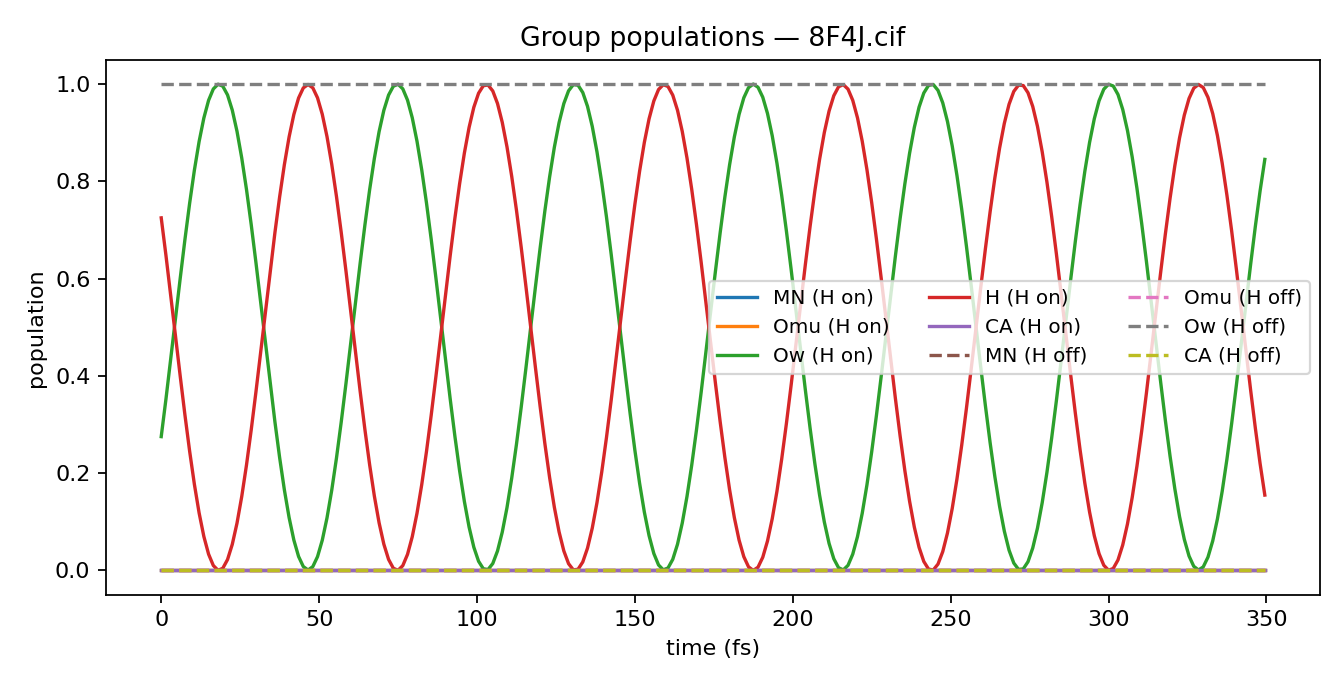

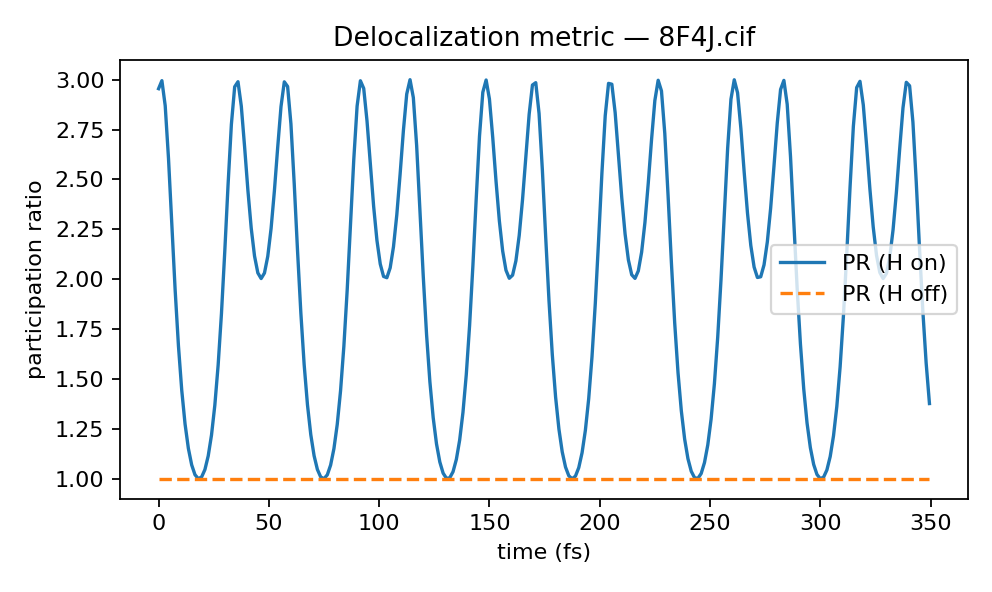

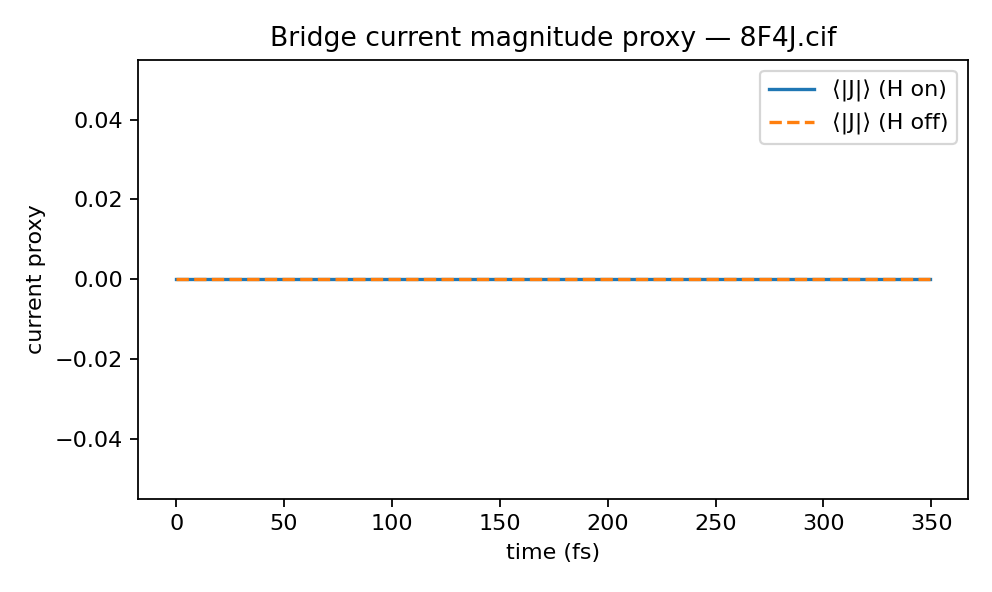

Saved GIF: /content/cubane_8F4J.cif_H_ON.gif


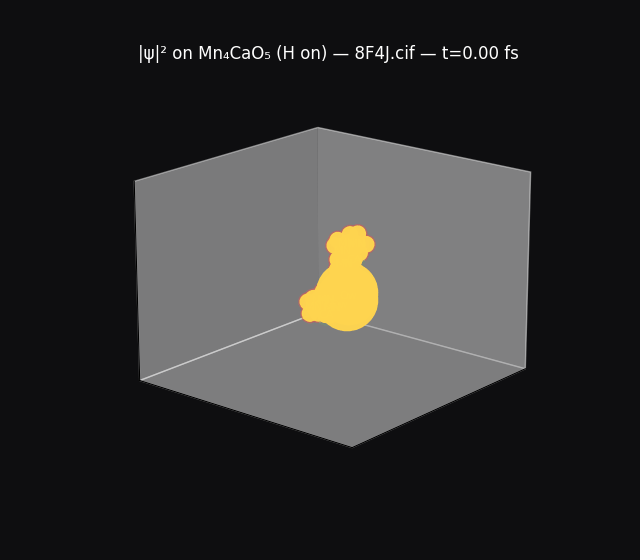

In [ ]:
# ======================== PATCH: labeling, scaffold, current, visuals ========================
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display
from scipy.spatial import cKDTree

basename = os.path.basename(CIF_PATH)

# --- helper: select edges we actually care about (Mn–Oμ and Ca–Ow; fallback Mn–Ow) ---
def select_scaffold_edges(X, tags, rc=3.4):
    tree = cKDTree(X); E=[]
    for i in range(len(X)):
        for j in tree.query_ball_point(X[i], r=rc):
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            ti, tj = tags[i], tags[j]
            mn_omu = (ti=="MN" and tj=="Omu") or (tj=="MN" and ti=="Omu")
            ca_ow  = (ti=="CA" and tj=="Ow")  or (tj=="CA" and ti=="Ow")
            mn_ow  = (ti=="MN" and tj=="Ow")  or (tj=="MN" and ti=="Ow")
            if mn_omu or ca_ow:
                E.append((i,j))
    # graceful fallback if nothing found
    if not E:
        for i in range(len(X)):
            for j in tree.query_ball_point(X[i], r=rc):
                if j<=i or np.linalg.norm(X[i]-X[j])<=0.5: continue
                ti, tj = tags[i], tags[j]
                if (ti=="MN" and tj=="Ow") or (tj=="MN" and ti=="Ow"):
                    E.append((i,j))
    return E

# --- recompute current proxy robustly on meaningful bridges ---
def bridge_current(E, H, P, tags):
    # only keep edges that exist and have nonzero H
    bridges=[]
    for (i,j) in E:
        if abs(H[i,j])>0:
            ti,tj = tags[i], tags[j]
            ok = ((ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")) or
                  (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow"))
            if ok: bridges.append((i,j))
    J=[]
    for p in P:
        if not bridges:
            J.append(0.0); continue
        vals=[abs(H[i,j])*np.sqrt(float(p[i]*p[j])) for (i,j) in bridges]
        J.append(float(np.mean(vals)))
    return np.array(J)

# --- derive edges we’ll use for both runs ---
E_scaf_h = select_scaffold_edges(Xh, Th)
E_scaf_0 = select_scaffold_edges(X0, T0)

# --- recompute diagnostics and re-plot with CIF in titles ---
def groups(P, tags):
    G = ["MN","Omu","Ow","H","CA"]
    idx = {g:[i for i,t in enumerate(tags) if t==g] for g in G}
    labs=[g for g in G if idx[g]]
    mat = np.stack([P[...,idx[g]].sum(-1) for g in labs], axis=-1) if labs else np.zeros((len(P),0))
    return labs, mat

def PR(p): s1=p.sum(-1); s2=(p**2).sum(-1); return (s1*s1)/(s2+1e-12)

labsH, GPH = groups(Ph, Th)
labs0, GP0 = groups(P0, T0)
PR_h, PR_0 = PR(Ph), PR(P0)
J_h = bridge_current(E_scaf_h, Hh, Ph, Th)
J_0 = bridge_current(E_scaf_0, H0, P0, T0)

outdir = "/content" if os.path.isdir("/content") else "."
pop_png = os.path.join(outdir, f"cubane_{basename}_pop.png")
pr_png  = os.path.join(outdir, f"cubane_{basename}_PR.png")
cur_png = os.path.join(outdir, f"cubane_{basename}_currents.png")

plt.figure(figsize=(8.4,4.3))
for k,nm in enumerate(labsH): plt.plot(Thm, GPH[:,k], label=f"{nm} (H on)")
for k,nm in enumerate(labs0):
    ls="--" if nm in labsH else ":"
    plt.plot(T0m, GP0[:,k], ls, label=f"{nm} (H off)")
plt.xlabel("time (fs)"); plt.ylabel("population")
plt.title(f"Group populations — {basename}")
plt.legend(ncol=3, fontsize=9); plt.tight_layout(); plt.savefig(pop_png, dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, PR_h,  label="PR (H on)")
plt.plot(T0m, PR_0, "--", label="PR (H off)")
plt.xlabel("time (fs)"); plt.ylabel("participation ratio")
plt.title(f"Delocalization metric — {basename}")
plt.legend(); plt.tight_layout(); plt.savefig(pr_png, dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, J_h,  label="⟨|J|⟩ (H on)")
plt.plot(T0m, J_0, "--", label="⟨|J|⟩ (H off)")
plt.xlabel("time (fs)"); plt.ylabel("current proxy")
plt.title(f"Bridge current magnitude proxy — {basename}")
plt.legend(); plt.tight_layout(); plt.savefig(cur_png, dpi=160); plt.close()

print("Saved:", pop_png, pr_png, cur_png)
display(Image(pop_png)); display(Image(pr_png)); display(Image(cur_png))

# --- higher-contrast GIF (translucent scaffold, bright popcorn ψ, CIF in title) ---
def col(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
def rad(t): return {"MN":1.00,"CA":0.85,"Omu":0.70,"Ow":0.65,"H":0.40}.get(t,0.55)

fig = plt.figure(figsize=(6.4,5.6)); ax = fig.add_subplot(111, projection="3d")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
fig.patch.set_facecolor("#0E0E10"); ax.set_facecolor("#0E0E10")
mn, mx = Xh.min(0), Xh.max(0); pad=1.2
ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)

# draw only scaffold edges
for (i,j) in E_scaf_h:
    ax.plot([Xh[i,0],Xh[j,0]],[Xh[i,1],Xh[j,1]],[Xh[i,2],Xh[j,2]], lw=2.8, alpha=0.95, color="#6C757D")

# static translucent atoms + bright dynamic ψ
stat_cols=[col(t) for t in Th]; stat_sizes=[240*rad(t) for t in Th]
stat = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=stat_sizes, c=stat_cols, alpha=0.35, depthshade=False)
dyn  = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=120, c="#FFD54F", alpha=0.98, depthshade=False)

# label only key species to reduce clutter
for i,t in enumerate(Th):
    if t in ("MN","CA","Ow"):
        ax.text(Xh[i,0],Xh[i,1],Xh[i,2], t, color="w", fontsize=8, ha="center", va="center")

ax.view_init(18, 40)

def upd(f):
    p = Ph[f]; p = p/(p.max()+1e-12)
    # nonlinear size to accentuate “popcorn”
    dyn.set_sizes(120 + 1800*np.sqrt(p))
    ax.set_title(f"|ψ|² on Mn₄CaO₅ (H on) — {basename} — t={Thm[f]:.2f} fs", color="w")
    return [dyn, stat]

gif_path = os.path.join(outdir, f"cubane_{basename}_H_ON.gif")
ani = animation.FuncAnimation(fig, upd, frames=len(Ph), interval=30, blit=False)
ani.save(gif_path, writer=animation.PillowWriter(fps=20)); plt.close(fig)
print("Saved GIF:", gif_path)
display(Image(gif_path))
# =============================================================================================

Saved: /content/cubane_8F4J.cif_pop.png /content/cubane_8F4J.cif_PR.png /content/cubane_8F4J.cif_currents.png


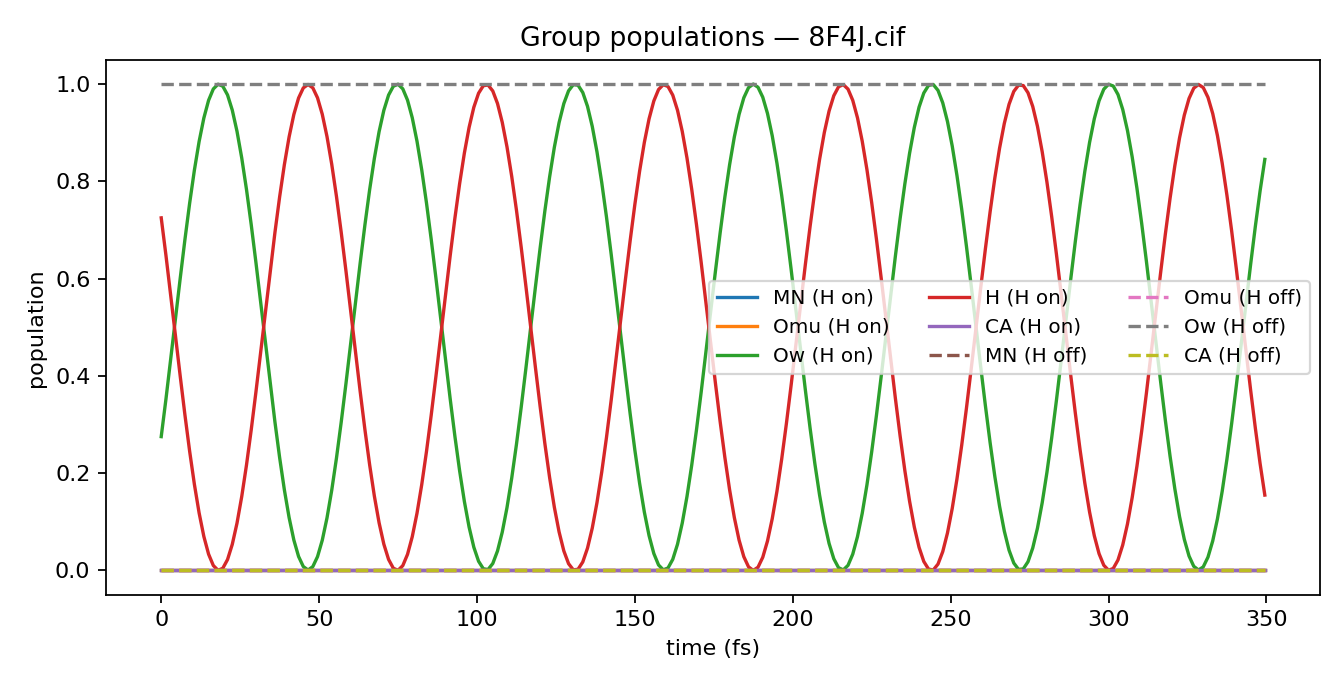

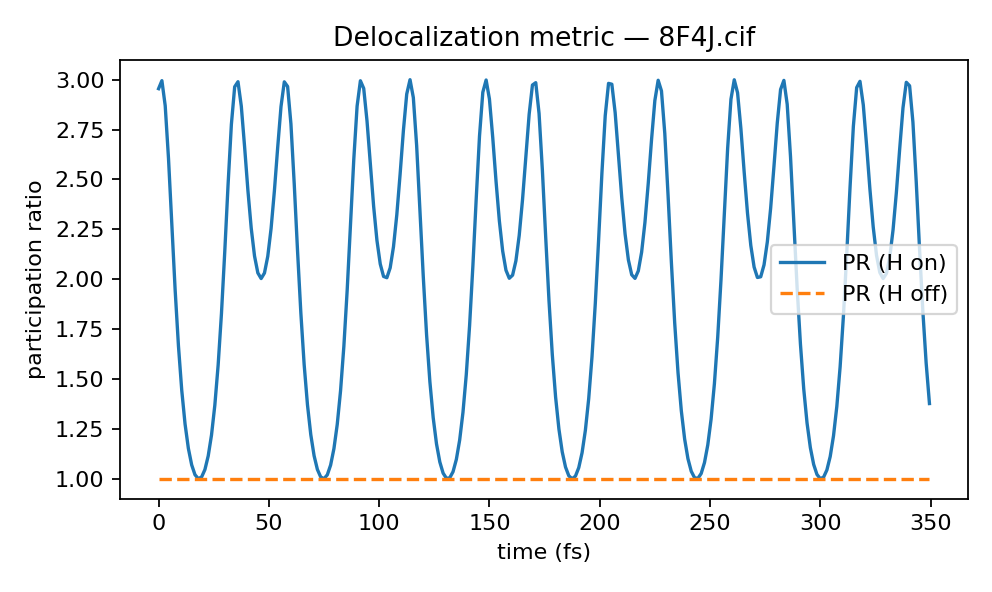

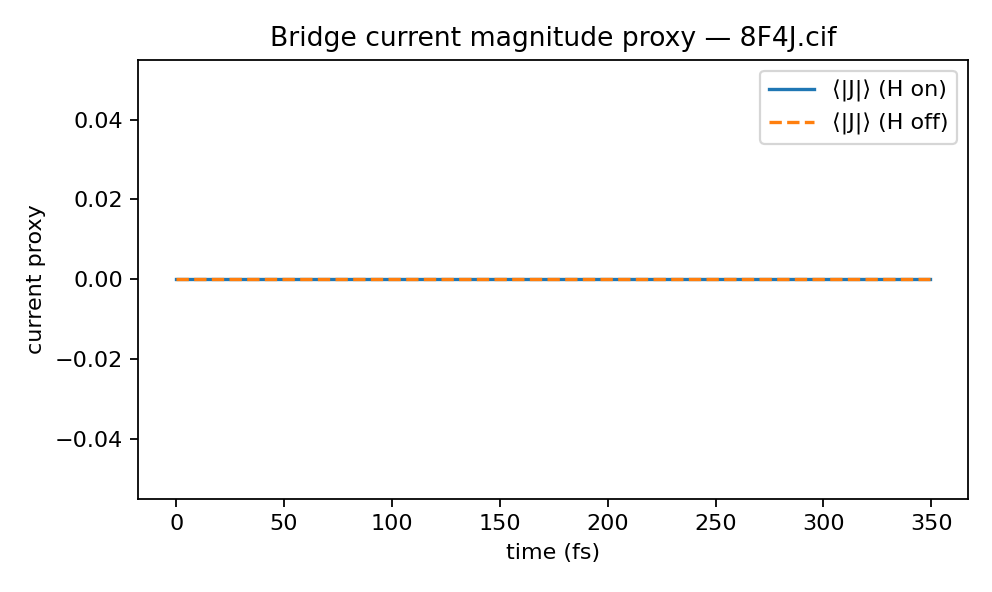

Saved GIF: /content/cubane_8F4J.cif_H_ON.gif


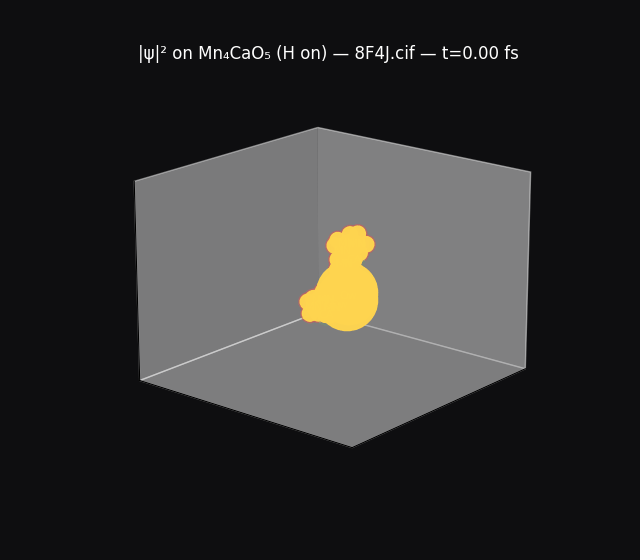

In [ ]:
# ======================== PATCH: labeling, scaffold, current, visuals ========================
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display
from scipy.spatial import cKDTree

basename = os.path.basename(CIF_PATH)

# --- helper: select edges we actually care about (Mn–Oμ and Ca–Ow; fallback Mn–Ow) ---
def select_scaffold_edges(X, tags, rc=3.4):
    tree = cKDTree(X); E=[]
    for i in range(len(X)):
        for j in tree.query_ball_point(X[i], r=rc):
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            ti, tj = tags[i], tags[j]
            mn_omu = (ti=="MN" and tj=="Omu") or (tj=="MN" and ti=="Omu")
            ca_ow  = (ti=="CA" and tj=="Ow")  or (tj=="CA" and ti=="Ow")
            mn_ow  = (ti=="MN" and tj=="Ow")  or (tj=="MN" and ti=="Ow")
            if mn_omu or ca_ow:
                E.append((i,j))
    # graceful fallback if nothing found
    if not E:
        for i in range(len(X)):
            for j in tree.query_ball_point(X[i], r=rc):
                if j<=i or np.linalg.norm(X[i]-X[j])<=0.5: continue
                ti, tj = tags[i], tags[j]
                if (ti=="MN" and tj=="Ow") or (tj=="MN" and ti=="Ow"):
                    E.append((i,j))
    return E

# --- recompute current proxy robustly on meaningful bridges ---
def bridge_current(E, H, P, tags):
    # only keep edges that exist and have nonzero H
    bridges=[]
    for (i,j) in E:
        if abs(H[i,j])>0:
            ti,tj = tags[i], tags[j]
            ok = ((ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")) or
                  (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow"))
            if ok: bridges.append((i,j))
    J=[]
    for p in P:
        if not bridges:
            J.append(0.0); continue
        vals=[abs(H[i,j])*np.sqrt(float(p[i]*p[j])) for (i,j) in bridges]
        J.append(float(np.mean(vals)))
    return np.array(J)

# --- derive edges we’ll use for both runs ---
E_scaf_h = select_scaffold_edges(Xh, Th)
E_scaf_0 = select_scaffold_edges(X0, T0)

# --- recompute diagnostics and re-plot with CIF in titles ---
def groups(P, tags):
    G = ["MN","Omu","Ow","H","CA"]
    idx = {g:[i for i,t in enumerate(tags) if t==g] for g in G}
    labs=[g for g in G if idx[g]]
    mat = np.stack([P[...,idx[g]].sum(-1) for g in labs], axis=-1) if labs else np.zeros((len(P),0))
    return labs, mat

def PR(p): s1=p.sum(-1); s2=(p**2).sum(-1); return (s1*s1)/(s2+1e-12)

labsH, GPH = groups(Ph, Th)
labs0, GP0 = groups(P0, T0)
PR_h, PR_0 = PR(Ph), PR(P0)
J_h = bridge_current(E_scaf_h, Hh, Ph, Th)
J_0 = bridge_current(E_scaf_0, H0, P0, T0)

outdir = "/content" if os.path.isdir("/content") else "."
pop_png = os.path.join(outdir, f"cubane_{basename}_pop.png")
pr_png  = os.path.join(outdir, f"cubane_{basename}_PR.png")
cur_png = os.path.join(outdir, f"cubane_{basename}_currents.png")

plt.figure(figsize=(8.4,4.3))
for k,nm in enumerate(labsH): plt.plot(Thm, GPH[:,k], label=f"{nm} (H on)")
for k,nm in enumerate(labs0):
    ls="--" if nm in labsH else ":"
    plt.plot(T0m, GP0[:,k], ls, label=f"{nm} (H off)")
plt.xlabel("time (fs)"); plt.ylabel("population")
plt.title(f"Group populations — {basename}")
plt.legend(ncol=3, fontsize=9); plt.tight_layout(); plt.savefig(pop_png, dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, PR_h,  label="PR (H on)")
plt.plot(T0m, PR_0, "--", label="PR (H off)")
plt.xlabel("time (fs)"); plt.ylabel("participation ratio")
plt.title(f"Delocalization metric — {basename}")
plt.legend(); plt.tight_layout(); plt.savefig(pr_png, dpi=160); plt.close()

plt.figure(figsize=(6.2,3.7))
plt.plot(Thm, J_h,  label="⟨|J|⟩ (H on)")
plt.plot(T0m, J_0, "--", label="⟨|J|⟩ (H off)")
plt.xlabel("time (fs)"); plt.ylabel("current proxy")
plt.title(f"Bridge current magnitude proxy — {basename}")
plt.legend(); plt.tight_layout(); plt.savefig(cur_png, dpi=160); plt.close()

print("Saved:", pop_png, pr_png, cur_png)
display(Image(pop_png)); display(Image(pr_png)); display(Image(cur_png))

# --- higher-contrast GIF (translucent scaffold, bright popcorn ψ, CIF in title) ---
def col(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
def rad(t): return {"MN":1.00,"CA":0.85,"Omu":0.70,"Ow":0.65,"H":0.40}.get(t,0.55)

fig = plt.figure(figsize=(6.4,5.6)); ax = fig.add_subplot(111, projection="3d")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
fig.patch.set_facecolor("#0E0E10"); ax.set_facecolor("#0E0E10")
mn, mx = Xh.min(0), Xh.max(0); pad=1.2
ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)

# draw only scaffold edges
for (i,j) in E_scaf_h:
    ax.plot([Xh[i,0],Xh[j,0]],[Xh[i,1],Xh[j,1]],[Xh[i,2],Xh[j,2]], lw=2.8, alpha=0.95, color="#6C757D")

# static translucent atoms + bright dynamic ψ
stat_cols=[col(t) for t in Th]; stat_sizes=[240*rad(t) for t in Th]
stat = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=stat_sizes, c=stat_cols, alpha=0.35, depthshade=False)
dyn  = ax.scatter(Xh[:,0],Xh[:,1],Xh[:,2], s=120, c="#FFD54F", alpha=0.98, depthshade=False)

# label only key species to reduce clutter
for i,t in enumerate(Th):
    if t in ("MN","CA","Ow"):
        ax.text(Xh[i,0],Xh[i,1],Xh[i,2], t, color="w", fontsize=8, ha="center", va="center")

ax.view_init(18, 40)

def upd(f):
    p = Ph[f]; p = p/(p.max()+1e-12)
    # nonlinear size to accentuate “popcorn”
    dyn.set_sizes(120 + 1800*np.sqrt(p))
    ax.set_title(f"|ψ|² on Mn₄CaO₅ (H on) — {basename} — t={Thm[f]:.2f} fs", color="w")
    return [dyn, stat]

gif_path = os.path.join(outdir, f"cubane_{basename}_H_ON.gif")
ani = animation.FuncAnimation(fig, upd, frames=len(Ph), interval=30, blit=False)
ani.save(gif_path, writer=animation.PillowWriter(fps=20)); plt.close(fig)
print("Saved GIF:", gif_path)
display(Image(gif_path))
# =============================================================================================

Found: {'8F4H.cif': '/content/8F4H.cif', '8F4I.cif': '/content/8F4I.cif', '8F4J.cif': '/content/8F4J.cif'}
[8F4H.cif] n(Mn)=16 n(Oμ)=44  <Mn–Oμ>=2.032Å±0.261Å  <∠Mn–Oμ–Mn>=16.4°±32.1°
Saved: /content/cubane_8F4H.cif_PR_sharp.png /content/cubane_8F4H.cif_currents_sharp.png
Saved GIF: /content/cubane_8F4H.cif_sharp.gif
[8F4I.cif] n(Mn)=16 n(Oμ)=44  <Mn–Oμ>=2.015Å±0.247Å  <∠Mn–Oμ–Mn>=12.9°±26.4°
Saved: /content/cubane_8F4I.cif_PR_sharp.png /content/cubane_8F4I.cif_currents_sharp.png
Saved GIF: /content/cubane_8F4I.cif_sharp.gif
[8F4J.cif] n(Mn)=16 n(Oμ)=44  <Mn–Oμ>=2.015Å±0.247Å  <∠Mn–Oμ–Mn>=12.9°±26.4°
Saved: /content/cubane_8F4J.cif_PR_sharp.png /content/cubane_8F4J.cif_currents_sharp.png
Saved GIF: /content/cubane_8F4J.cif_sharp.gif
Saved: /content/cubane_PR_overlay_sharp.png
Saved: /content/cubane_currents_overlay_sharp.png


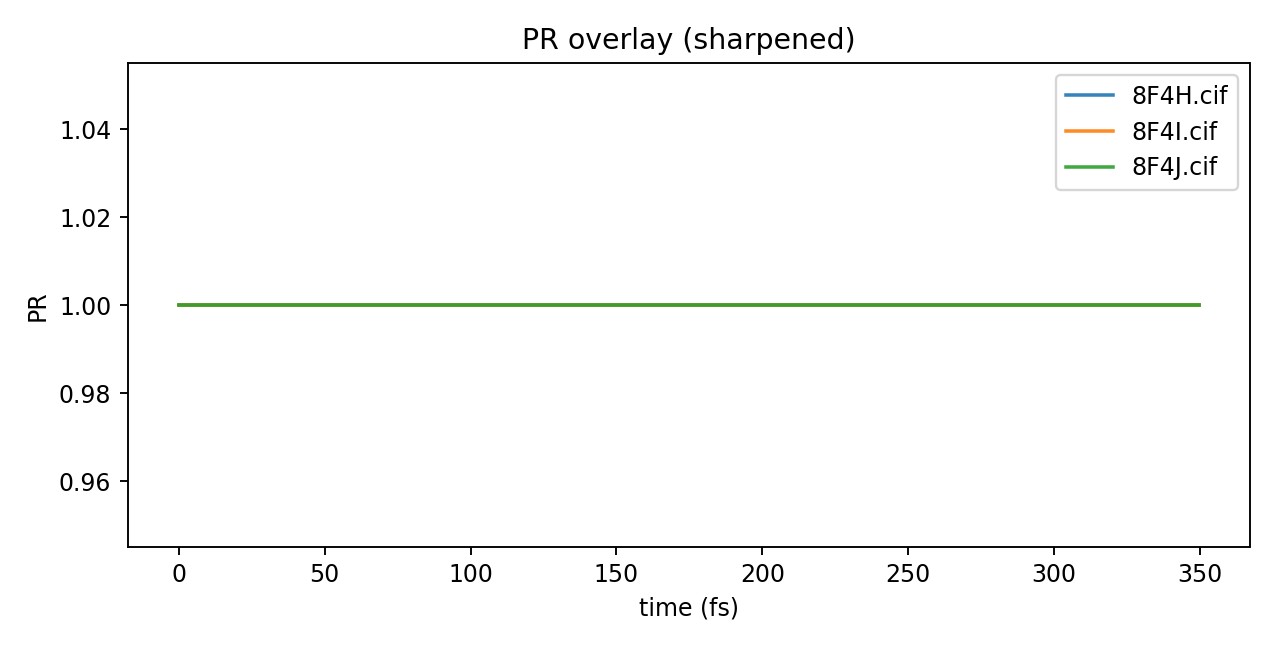

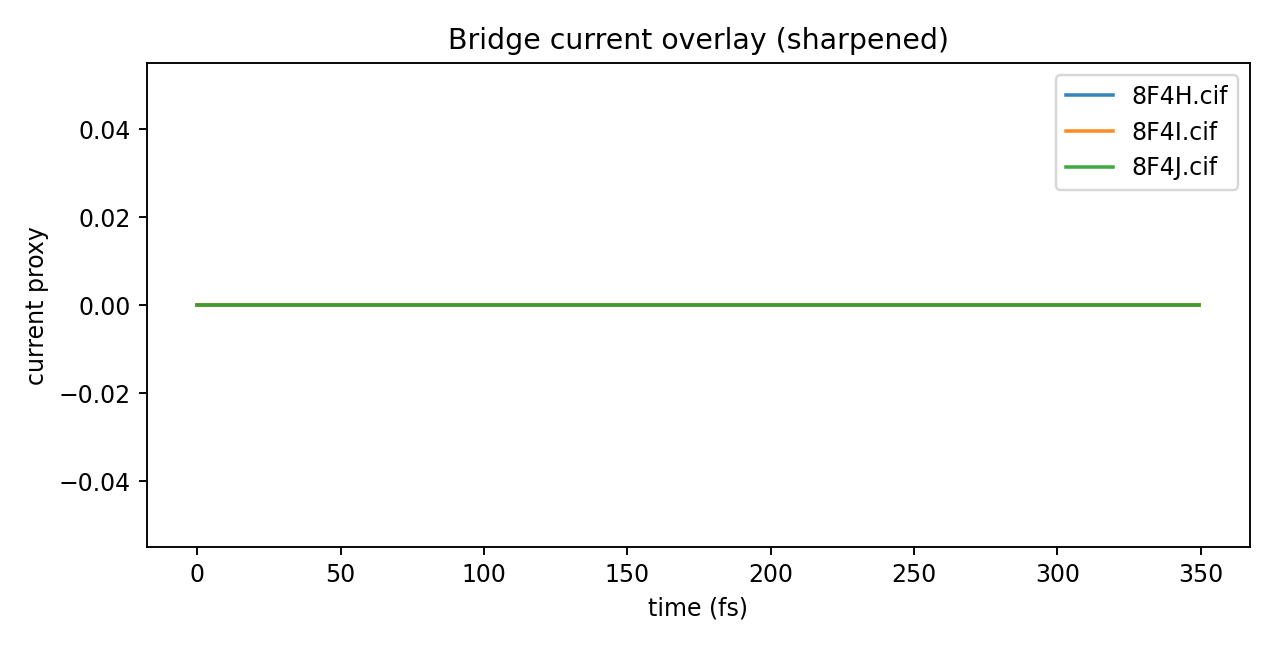

In [ ]:
h# ================= MULTI-CIF (H/I/J) GEOMETRY + SHARP TDSE OVERLAY =================
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# --- light deps ---
import sys, subprocess
def need(pkg, mod=None):
    try: __import__(mod or pkg)
    except Exception: subprocess.check_call([sys.executable,"-m","pip","install","-q",pkg])
need("gemmi"); import gemmi
need("scipy"); from scipy.spatial import cKDTree

# --- locate CIFs ---
SEARCH = ["/content", "/content/sample_data", "./", "./sample_data"]
NAMES  = ["8F4H.cif","8F4I.cif","8F4J.cif"]
FOUND  = {}
for nm in NAMES:
    for root in SEARCH:
        p = os.path.join(root,nm)
        if os.path.isfile(p):
            FOUND[nm] = p; break
if not FOUND:
    raise FileNotFoundError("Could not find any of 8F4H/8F4I/8F4J in /content or ./sample_data")

OUTDIR = "/content" if os.path.isdir("/content") else "."
print("Found:", FOUND)

# --- shared helpers (read, tag, μ-oxo, angles) ---
def read_atoms(cif_path):
    try: st = gemmi.read_structure(cif_path)
    except: st = gemmi.make_structure_from_block(gemmi.cif.read_file(cif_path)[0])
    if hasattr(st,"remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except: pass
    m = st[0]
    atoms=[]
    for ch in m:
        for res in ch:
            for at in res:
                p=at.pos
                atoms.append((np.array([p.x,p.y,p.z],np.float32),
                              at.element.name.upper(),
                              res.name.upper()))
    return atoms

def identify_core(coords, elem, resn):
    mn_idx = [i for i,e in enumerate(elem) if e=="MN"]
    ca_idx = [i for i,e in enumerate(elem) if e=="CA"]
    O_idx  = [i for i,e in enumerate(elem) if e=="O"]
    # μ-oxo = O near ≥2 Mn within 2.7 Å
    mu=[]
    for i in O_idx:
        if not mn_idx: continue
        d = np.linalg.norm(coords[mn_idx]-coords[i], axis=1)
        if (d<=2.7).sum()>=2: mu.append(i)
    # W3/W4 candidates: O not μ-oxo nearest to Mn/Ca centroid
    w_candidates = [i for i in O_idx if i not in mu]
    center = coords[(mn_idx + ca_idx)].mean(axis=0) if (mn_idx or ca_idx) else coords.mean(0)
    dW = [(i, float(np.linalg.norm(coords[i]-center))) for i in w_candidates]
    dW.sort(key=lambda x:x[1]); W = [dW[k][0] for k in range(min(2,len(dW)))]
    # build node set and tags
    core = sorted(set(mn_idx + ca_idx + mu + W))
    X = coords[core].copy()
    tags=[]
    for i in core:
        if elem[i]=="MN": tags.append("MN")
        elif elem[i]=="CA": tags.append("CA")
        elif elem[i]=="O":
            tags.append("Omu" if i in mu else ("Ow" if i in W else "O"))
        else: tags.append(elem[i])
    return X, tags, {"mn":mn_idx, "mu":mu, "W":W}

def mu_angles(coords, mn_idx, o_idx):
    out=[]
    for iO in o_idx:
        d = [(j, float(np.linalg.norm(coords[j]-coords[iO]))) for j in mn_idx]
        if len(d) < 2: continue
        d.sort(key=lambda x:x[1])
        a,b = d[0][0], d[1][0]
        v1, v2 = coords[a]-coords[iO], coords[b]-coords[iO]
        c = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-12)
        out.append(np.arccos(np.clip(c,-1,1)))
    return np.array(out, float)

# --- sharpened TDSE (same for all) ---
PAIR_RC   = 3.40
BETA_SH   = 2.00
LAM_SH    = 1.20
BREATH_A  = 0.12
BREATH_T  = 100.0
DT_SH     = 0.5
STEPS_SH  = 700
FRAME_EVERY = 3
eps0 = dict(MN=0.0, Omu=-0.40, Ow=-0.35, H=-0.10, CA=+0.60)

def build_edges(X, rc=PAIR_RC):
    tree=cKDTree(X); E=[]
    for i in range(len(X)):
        for j in tree.query_ball_point(X[i], r=rc):
            if j<=i: continue
            if np.linalg.norm(X[i]-X[j])<=0.5: continue
            E.append((i,j))
    return E

def angle_boost_at_Omu(iO, X, mn_list):
    if len(mn_list) < 2: return 1.0
    d = [(j, float(np.linalg.norm(X[j]-X[iO]))) for j in mn_list]
    d.sort(key=lambda x:x[1])
    a,b = d[0][0], d[1][0]
    v1, v2 = X[a]-X[iO], X[b]-X[iO]
    c = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-12)
    return 1.0 + LAM_SH*(c*c)

def build_H_sharp(X, tags, E, rnd_seed=1):
    N=len(X); H = np.zeros((N,N), complex)
    mn_list=[i for i,t in enumerate(tags) if t=="MN"]
    for (i,j) in E:
        ti,tj = tags[i], tags[j]
        r = float(np.linalg.norm(X[i]-X[j])); t = 0.0
        if (ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")):
            boost = 1.0
            if ti=="MN" and tj=="Omu": boost = angle_boost_at_Omu(j, X, mn_list)
            if tj=="MN" and ti=="Omu": boost = angle_boost_at_Omu(i, X, mn_list)
            t = np.exp(-BETA_SH*r) * boost
        elif (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow"):
            t = 0.6*np.exp(-BETA_SH*r)
        elif ti.startswith("O") and tj.startswith("O"):
            t = 0.08*np.exp(-BETA_SH*r)
        if t!=0.0: H[i,j]=t; H[j,i]=t
    rng = np.random.default_rng(rnd_seed)
    for i,tg in enumerate(tags):
        H[i,i] = eps0.get(tg, 0.0) + 0.02*(rng.random()-0.5)
    return H

def tdse_sharp(X, tags, basename):
    E = build_edges(X)
    seed = abs(hash(basename)) % (2**32)
    H0 = build_H_sharp(X, tags, E, rnd_seed=seed)
    try: s = next(i for i,t in enumerate(tags) if t=="Ow")
    except StopIteration: s = 0
    psi = np.zeros(len(X), complex); psi[s]=1.0
    frames=[]; times=[]
    mn_o_pairs = [(i,j) for (i,j) in E
                  if (tags[i]=="MN" and tags[j].startswith("O")) or (tags[j]=="MN" and tags[i].startswith("O"))]
    for n in range(STEPS_SH):
        gate = 1.0 + BREATH_A*np.sin(2*np.pi*(n*DT_SH)/BREATH_T)
        Ht = H0.copy()
        for (i,j) in mn_o_pairs: Ht[i,j] *= gate; Ht[j,i] *= gate
        Evals, V = np.linalg.eigh(Ht)
        U = V @ np.diag(np.exp(-1j*Evals*DT_SH)) @ V.conj().T
        psi = U @ psi; psi /= (np.linalg.norm(psi)+1e-12)
        if n % FRAME_EVERY == 0:
            frames.append((np.abs(psi)**2).astype(np.float32))
            times.append(n*DT_SH)
    return np.array(frames), np.array(times), E, H0

def PR(p): s1=p.sum(-1); s2=(p**2).sum(-1); return (s1*s1)/(s2+1e-12)
def select_bridges(E, H, tags):
    B=[]
    for (i,j) in E:
        if abs(H[i,j])==0: continue
        ti,tj = tags[i], tags[j]
        if ((ti=="MN" and tj.startswith("O")) or (tj=="MN" and ti.startswith("O")) or
            (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow")):
            B.append((i,j))
    return B
def J_of(P, H, bridges):
    if not bridges: return np.zeros(len(P))
    out=[]
    for p in P:
        out.append(np.mean([abs(H[i,j])*np.sqrt(float(p[i]*p[j])) for (i,j) in bridges]))
    return np.array(out)

# --- loop H/I/J: diagnostics, TDSE, per-CIF plots, small GIF ---
results = {}
for nm, path in FOUND.items():
    atoms   = read_atoms(path)
    coords  = np.array([a[0] for a in atoms], np.float32)
    elem    = [a[1] for a in atoms]
    resn    = [a[2] for a in atoms]
    X,tags,idx = identify_core(coords, elem, resn)
    mn_idx, mu_idx = idx["mn"], idx["mu"]
    # diagnostics
    angles = mu_angles(X, [i for i,t in enumerate(tags) if t=="MN"], [i for i,t in enumerate(tags) if t=="Omu"])
    # nearest Mn–Oμ distances
    dists=[]
    Mn_local = [i for i,t in enumerate(tags) if t=="MN"]
    for iO in [i for i,t in enumerate(tags) if t=="Omu"]:
        if not Mn_local: continue
        d = np.linalg.norm(X[Mn_local]-X[iO], axis=1)
        dists.extend(d[d<=3.0])
    dists = np.array(dists)
    if len(dists) and len(angles):
        print(f"[{nm}] n(Mn)={len(Mn_local)} n(Oμ)={len([i for i,t in enumerate(tags) if t=='Omu'])}  "
              f"<Mn–Oμ>={dists.mean():.3f}Å±{dists.std():.3f}Å  "
              f"<∠Mn–Oμ–Mn>={np.degrees(angles).mean():.1f}°±{np.degrees(angles).std():.1f}°")
    else:
        print(f"[{nm}] diagnostics: insufficient μ-oxo stats")

    # TDSE
    P,T,E,H = tdse_sharp(X, tags, nm)
    PRv = PR(P); Jv = J_of(P, H, select_bridges(E,H,tags))
    # save per-CIF plots
    pr_png  = os.path.join(OUTDIR, f"cubane_{nm}_PR_sharp.png")
    cur_png = os.path.join(OUTDIR, f"cubane_{nm}_currents_sharp.png")
    plt.figure(figsize=(6.0,3.6)); plt.plot(T, PRv); plt.xlabel("time (fs)"); plt.ylabel("PR")
    plt.title(f"PR — {nm}"); plt.tight_layout(); plt.savefig(pr_png, dpi=160); plt.close()
    plt.figure(figsize=(6.0,3.6)); plt.plot(T, Jv); plt.xlabel("time (fs)"); plt.ylabel("current proxy")
    plt.title(f"Bridges ⟨|J|⟩ — {nm}"); plt.tight_layout(); plt.savefig(cur_png, dpi=160); plt.close()
    print("Saved:", pr_png, cur_png)

    # quick GIF (cubane bridges highlighted)
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    def col(t): return {"MN":"#BA68C8","CA":"#66BB6A","Omu":"#EF5350","Ow":"#00E5FF","H":"#FFD54F"}.get(t,"#BDBDBD")
    def rad(t): return {"MN":1.00,"CA":0.85,"Omu":0.70,"Ow":0.65,"H":0.40}.get(t,0.55)
    fig = plt.figure(figsize=(6.0,5.2)); ax = fig.add_subplot(111, projection="3d")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(False)
    fig.patch.set_facecolor("#0E0E10"); ax.set_facecolor("#0E0E10")
    mn, mx = X.min(0), X.max(0); pad=1.2
    ax.set_xlim(mn[0]-pad, mx[0]+pad); ax.set_ylim(mn[1]-pad, mx[1]+pad); ax.set_zlim(mn[2]-pad, mx[2]+pad)
    # draw only Mn–Oμ and Ca–Ow
    for (i,j) in E:
        ti,tj = tags[i], tags[j]
        keep = ((ti=="MN" and tj=="Omu") or (tj=="MN" and ti=="Omu") or
                (ti=="CA" and tj=="Ow") or (tj=="CA" and ti=="Ow"))
        if keep:
            ax.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]],[X[i,2],X[j,2]], lw=2.6, alpha=0.95, color="#6C757D")
    stat = ax.scatter(X[:,0],X[:,1],X[:,2],
                      s=[240*rad(t) for t in tags], c=[col(t) for t in tags],
                      alpha=0.35, depthshade=False)
    dyn  = ax.scatter(X[:,0],X[:,1],X[:,2], s=120, c="#FFD54F", alpha=0.98, depthshade=False)
    ax.view_init(18, 40)
    def upd(f):
        p = P[f]; p = p/(p.max()+1e-12)
        dyn.set_sizes(120 + 1800*np.sqrt(p))
        ax.set_title(f"|ψ|² (sharp)—{nm}—t={T[f]:.2f} fs", color="w"); return [dyn, stat]
    gif = os.path.join(OUTDIR, f"cubane_{nm}_sharp.gif")
    ani = animation.FuncAnimation(fig, upd, frames=len(P), interval=30, blit=False)
    ani.save(gif, writer=animation.PillowWriter(fps=20)); plt.close(fig)
    print("Saved GIF:", gif)

    results[nm] = dict(T=T, PR=PRv, J=Jv)

# --- overlay PR/current for all found CIFs ---
colors = {"8F4H.cif":"C0","8F4I.cif":"C1","8F4J.cif":"C3"}
plt.figure(figsize=(7.5,3.8))
for nm,data in results.items():
    plt.plot(data["T"], data["PR"], label=nm, alpha=0.9)
plt.xlabel("time (fs)"); plt.ylabel("PR"); plt.title("PR overlay (sharpened)")
plt.legend(); plt.tight_layout()
ov_pr = os.path.join(OUTDIR, "cubane_PR_overlay_sharp.png")
plt.savefig(ov_pr, dpi=170); plt.close()
print("Saved:", ov_pr)

plt.figure(figsize=(7.5,3.8))
for nm,data in results.items():
    plt.plot(data["T"], data["J"], label=nm, alpha=0.9)
plt.xlabel("time (fs)"); plt.ylabel("current proxy"); plt.title("Bridge current overlay (sharpened)")
plt.legend(); plt.tight_layout()
ov_j = os.path.join(OUTDIR, "cubane_currents_overlay_sharp.png")
plt.savefig(ov_j, dpi=170); plt.close()
print("Saved:", ov_j)

display(Image(ov_pr)); display(Image(ov_j))
# ================================================================================